<a href="https://colab.research.google.com/github/mateusleonel/SeriesTemporais/blob/main/Trabalho_S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os


os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [ ]:
 # Instala o eaon
!pip install aeon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 17.9 MB/s eta 0:00:00


# Download do dataset

In [ ]:
import requests
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from aeon.transformations.collection.catch22 import Catch22
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn.metrics import confusion_matrix


SEED = 42

# Url do arquivo arff
arff_file_url = 'https://drive.google.com/uc?id=1aXtpHOlBB2YrQdbarb5bTtesQi7mqYAb'

# Download
response = requests.get(arff_file_url)
with open('EEG Eye State.arff', 'wb') as f:
    f.write(response.content)

# Load ARFF file
data, meta = arff.loadarff('EEG Eye State.arff')

# Converte para Pandas DataFrame
df = pd.DataFrame(data)


In [ ]:
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'


In [ ]:
df['eyeDetection'].unique()

array([b'0', b'1'], dtype=object)

# Criar os exemplos

Os dados são continuos, isto é, em um momento o paciente está de olhos abertos (b'0') e o outro ele está de olhos fechados (b'1')

In [ ]:
# Converte a coluna 'eyeDetection' para inteiro (0 ou 1)
df['eyeDetection'] = df['eyeDetection'].astype(str).str.strip("b'").astype(int)

# Procura os indices onde 'eyeDetection' muda de estado
change_indices = df[df['eyeDetection'].shift() != df['eyeDetection']].index

# Criar uma lista para guardar cada exemplo
X = [] # Lista para guardar todos os canais
y = [] # Lista para guardar somente a classe
X_channels = [] # Lista para guardar somente os canais selecionados (aqui vamos guardar somente os canis O1 e O2)

# Set o tamanho desejado que cada exemplo deve ter
desired_length = 50

# Intera sobre os indices que indica as mudanças de estado e cria os exemplos
for i in range(len(change_indices) - 1):
    start_index = change_indices[i]
    end_index = change_indices[i + 1]

    # Extrai a série temporal
    sample = df.iloc[start_index:end_index]

    # Padroniza o tamanho da série temporal conforme  'desired_length'
    if len(sample) >= desired_length:
        # Se o exemplo é maior que 'desired_length' então corta ele em segmentos. Se for menor ele descarta o segmento
        num_segments = len(sample) // desired_length
        remainder = len(sample) % desired_length
        segments = np.array_split(sample.iloc[:-remainder], num_segments)
        segments.append(sample.iloc[-remainder:])

        for segment in segments:
          if len(segment) == desired_length:
            # Se o exemplo é igual 'desired_length' ele armazena, se não for igual ele descarta o segmento
            epoch = np.array(segment.iloc[:desired_length,:-1]) # Seleciona somente os canais

            epoch_channels = np.array(segment.iloc[:desired_length, [6, 7]]) # Seleciona somente os canais que queremos extrair os atributos (no caso queremos do O1 e O1, cuja posição é [6, 7])

            X.append(epoch.reshape(epoch.shape[1], epoch.shape[0])) # Append de todos os canais
            X_channels.append(epoch_channels.reshape(epoch_channels.shape[1], epoch_channels.shape[0])) # Append dos canais especificos
            y.append(segment.iloc[0,-1]) # Append da classe


In [ ]:

unique_values, counts = np.unique(np.array(y), return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 160
Value: 1, Count: 130


# Plot de um exemplo

In [ ]:
from matplotlib import rcParams

rcParams['font.size'] = 10
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10


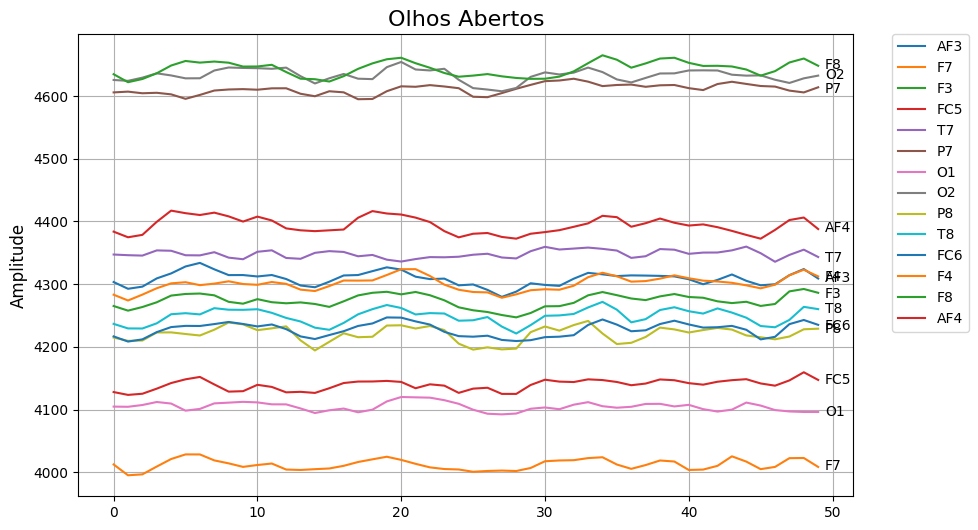

In [ ]:
# Plot exemplo da classe 0 (olho aberto)

sample1 = pd.DataFrame(X[1].reshape(X[1].shape[1], X[1].shape[0]), columns=df.columns[:-1])
# Define uma constante para melhor visualização
offset = 2

plt.figure(figsize=(10, 6))

# Intera sobre as colunas (eletrodos) e plot cada um com o respectivo nome
for i, column in enumerate(sample1.columns):
    jitter = np.random.uniform(-offset, offset, size=len(sample1))
    plt.plot(sample1.index, sample1[column] + i * offset + jitter, label=column)
    plt.annotate(column, xy=(len(sample1) - 1, sample1[column].iloc[-1] + i * offset),
                 xytext=(5, 0), textcoords='offset points', ha='left', va='center')

plt.title(f'Olhos Abertos')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.grid(True)
plt.savefig('olhos_abertos.pdf', dpi=300, bbox_inches='tight')
plt.show()


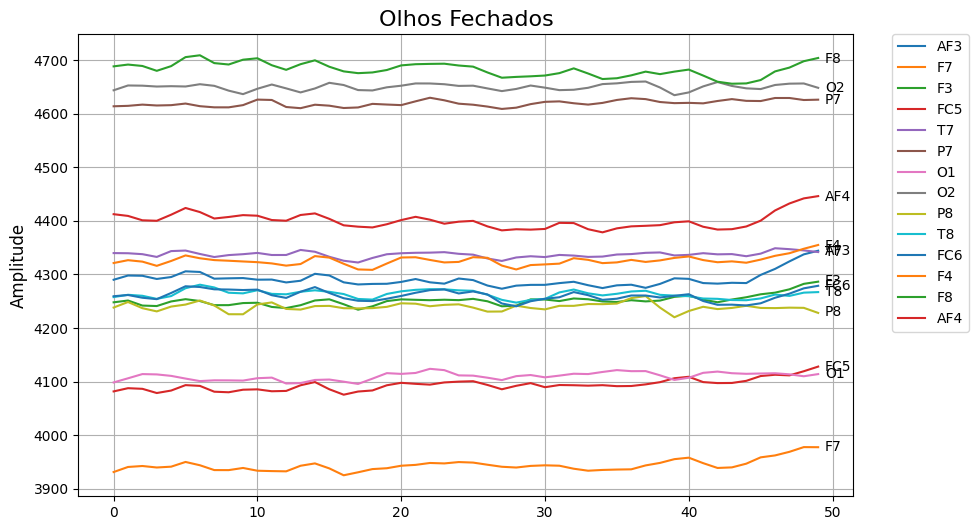

In [ ]:
# Plot exemplo da classe 1 (olho fechado)

sample4 = pd.DataFrame(X[4].reshape(X[4].shape[1], X[4].shape[0]), columns=df.columns[:-1])
# Define uma constante para melhor visualização
offset = 2

plt.figure(figsize=(10, 6))

# Intera sobre as colunas (eletrodos) e plot cada um com o respectivo nome
for i, column in enumerate(sample4.columns):
    jitter = np.random.uniform(-offset, offset, size=len(sample4))
    plt.plot(sample4.index, sample4[column] + i * offset + jitter, label=column)
    plt.annotate(column, xy=(len(sample4) - 1, sample4[column].iloc[-1] + i * offset),
                 xytext=(5, 0), textcoords='offset points', ha='left', va='center')

plt.title(f'Olhos Fechados')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.grid(True)
plt.savefig('olhos_fechados.pdf',dpi=300, bbox_inches='tight')
plt.show()

# Pré-processamento dos dados

Cria os arrays a partir das listas com os exemplos e embaralha as amostras

In [ ]:
X = np.stack(X)
y = np.stack(y)
X_channels = np.stack(X_channels)

X, X_channels, y = shuffle(X, X_channels, y, random_state=SEED)

# Define as Métricas de interesse

In [ ]:
def metrics(y_true, y_pred):
    acc = round(accuracy_score(y_true, y_pred), 3)
    f1 = round(f1_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)

    print(f'Accuracy: {acc}')
    print(f'F1 score: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    return acc, f1, precision, recall

In [ ]:
K_fold = 5
epochs = 100
batch_size = 8

# CNN - LSTM + Features de todos os canais

-------------------- Fold 1 --------------------
Epoch 1/100
29/29 [==============================] - 14s 7ms/step - loss: 0.9154 - accuracy: 0.4655
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.8493 - accuracy: 0.4784
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.8387 - accuracy: 0.4784
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.7411 - accuracy: 0.5431
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5733
Epoch 6/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6634 - accuracy: 0.6466
Epoch 7/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6086 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 0s 9ms/step - loss: 0.5694 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 0s 9ms/step - loss: 0.5815 - accuracy: 0.6810
Epoch 10/100
29/29 [==============================] - 0s 9m

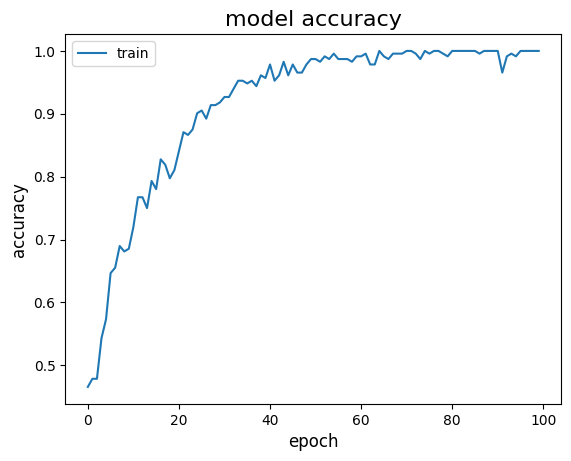

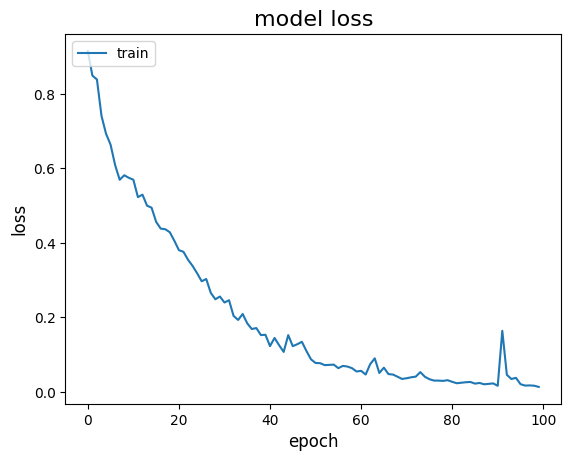

2/2 [==============================] - 0s 20ms/step
Accuracy: 0.69
F1 score: 0.667
Precision: 0.643
Recall: 0.692

 PERFORMANCE CNN - LSTM + Features
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        32
           1       0.64      0.69      0.67        26

    accuracy                           0.69        58
   macro avg       0.69      0.69      0.69        58
weighted avg       0.69      0.69      0.69        58



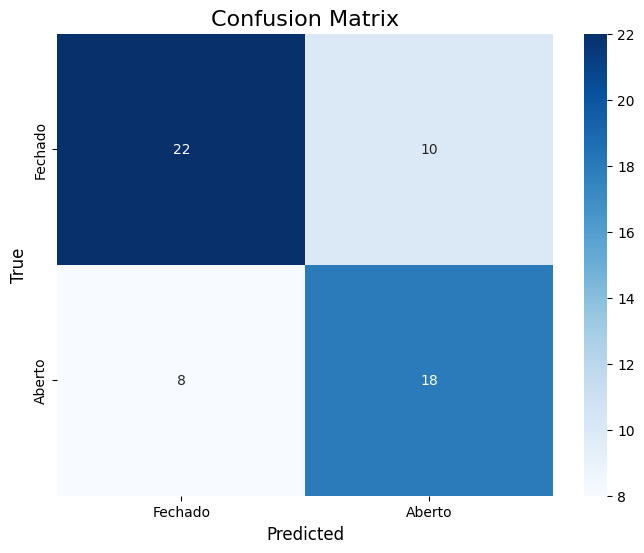

-------------------- Fold 2 --------------------
Epoch 1/100
29/29 [==============================] - 4s 7ms/step - loss: 0.9792 - accuracy: 0.4224
Epoch 2/100
29/29 [==============================] - 0s 10ms/step - loss: 0.8750 - accuracy: 0.4784
Epoch 3/100
29/29 [==============================] - 0s 11ms/step - loss: 0.7900 - accuracy: 0.5086
Epoch 4/100
29/29 [==============================] - 0s 10ms/step - loss: 0.7550 - accuracy: 0.4957
Epoch 5/100
29/29 [==============================] - 0s 9ms/step - loss: 0.7075 - accuracy: 0.5603
Epoch 6/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6658 - accuracy: 0.6250
Epoch 7/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6475 - accuracy: 0.6121
Epoch 8/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6248 - accuracy: 0.6466
Epoch 9/100
29/29 [==============================] - 0s 9ms/step - loss: 0.5835 - accuracy: 0.6767
Epoch 10/100
29/29 [==============================] - 0s 

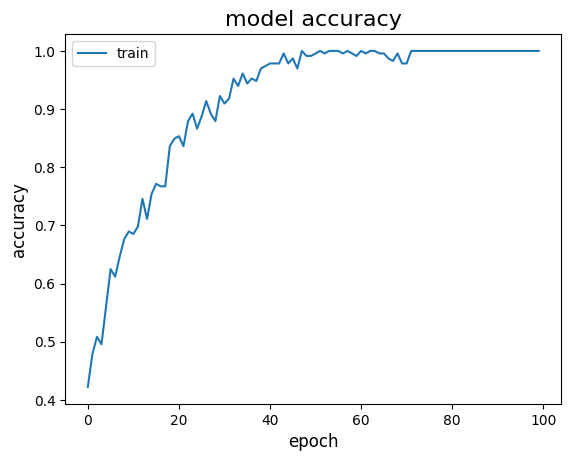

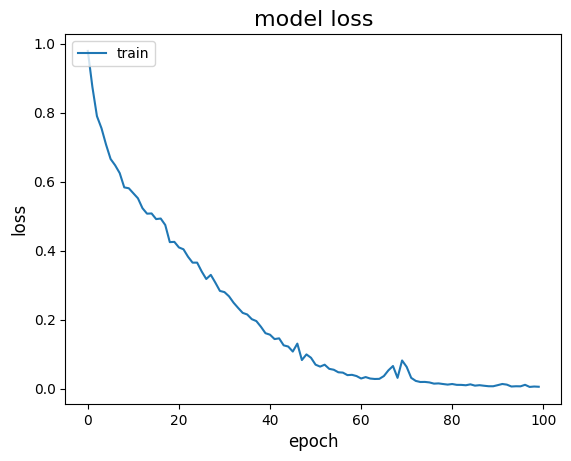

2/2 [==============================] - 0s 10ms/step
Accuracy: 0.776
F1 score: 0.755
Precision: 0.741
Recall: 0.769

 PERFORMANCE CNN - LSTM + Features
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        32
           1       0.74      0.77      0.75        26

    accuracy                           0.78        58
   macro avg       0.77      0.78      0.77        58
weighted avg       0.78      0.78      0.78        58



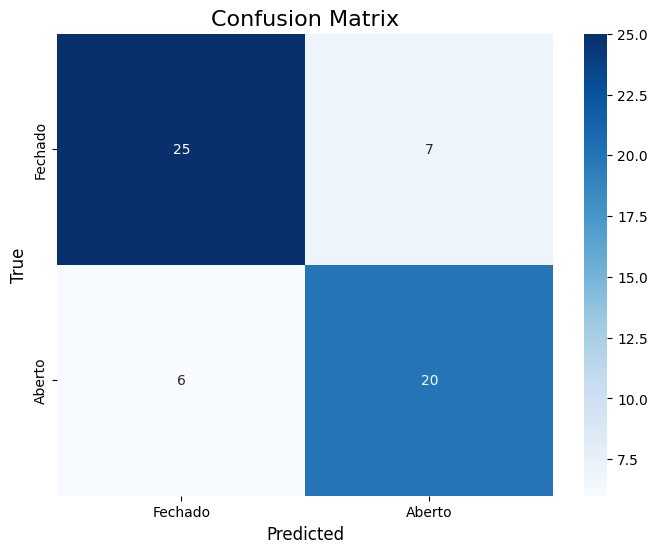

-------------------- Fold 3 --------------------
Epoch 1/100
29/29 [==============================] - 3s 10ms/step - loss: 0.8994 - accuracy: 0.4612
Epoch 2/100
29/29 [==============================] - 0s 9ms/step - loss: 0.8852 - accuracy: 0.4569
Epoch 3/100
29/29 [==============================] - 0s 9ms/step - loss: 0.8010 - accuracy: 0.4914
Epoch 4/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6816 - accuracy: 0.5819
Epoch 5/100
29/29 [==============================] - 0s 10ms/step - loss: 0.6785 - accuracy: 0.6121
Epoch 6/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6600 - accuracy: 0.6034
Epoch 7/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6148 - accuracy: 0.6681
Epoch 8/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6273 - accuracy: 0.6336
Epoch 9/100
29/29 [==============================] - 0s 8ms/step - loss: 0.5655 - accuracy: 0.7198
Epoch 10/100
29/29 [==============================] - 0s 9

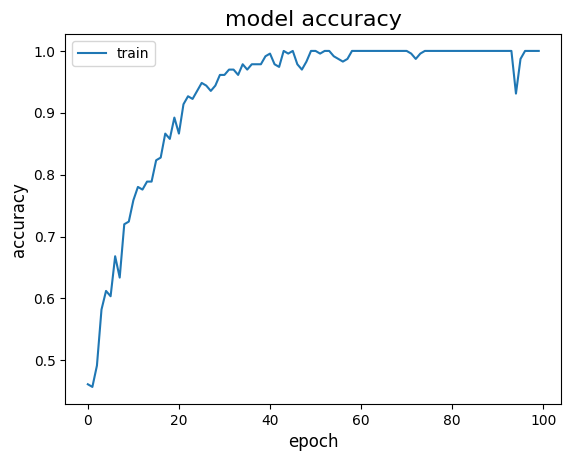

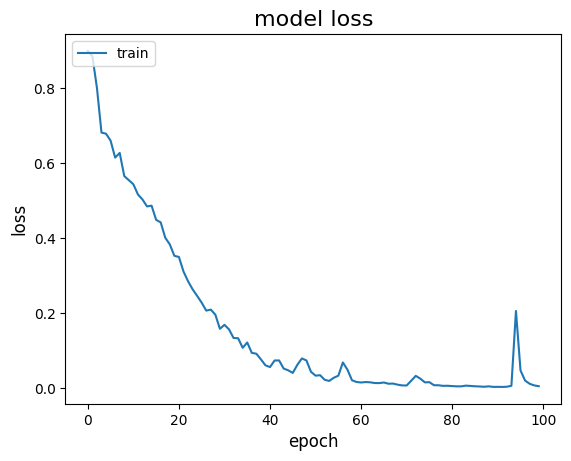

2/2 [==============================] - 0s 11ms/step
Accuracy: 0.793
F1 score: 0.769
Precision: 0.769
Recall: 0.769

 PERFORMANCE CNN - LSTM + Features
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       0.77      0.77      0.77        26

    accuracy                           0.79        58
   macro avg       0.79      0.79      0.79        58
weighted avg       0.79      0.79      0.79        58



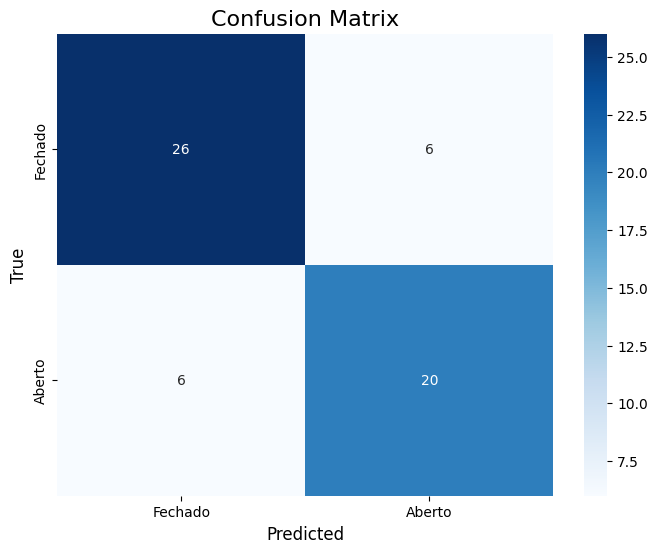

-------------------- Fold 4 --------------------
Epoch 1/100
29/29 [==============================] - 3s 7ms/step - loss: 0.9307 - accuracy: 0.4526
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.8613 - accuracy: 0.4784
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.7968 - accuracy: 0.5129
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.7411 - accuracy: 0.5302
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6886 - accuracy: 0.6034
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6534 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6100 - accuracy: 0.6509
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6194 - accuracy: 0.6250
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.5674 - accuracy: 0.6983
Epoch 10/100
29/29 [==============================] - 0s 7ms

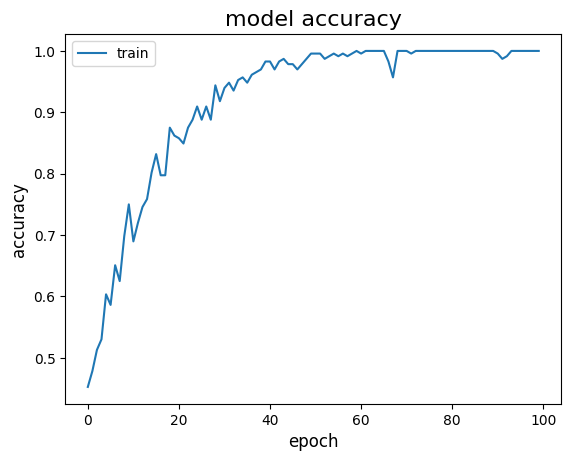

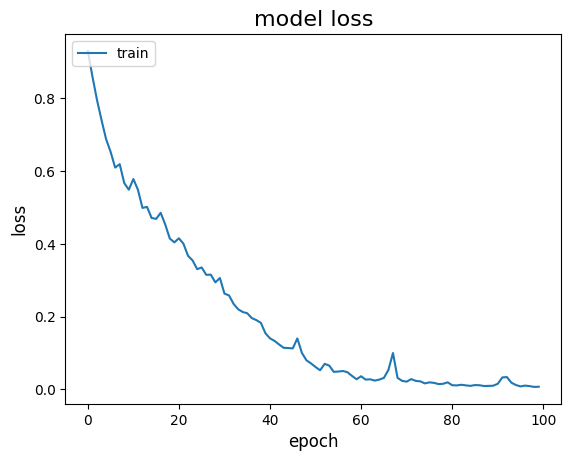

2/2 [==============================] - 0s 8ms/step
Accuracy: 0.69
F1 score: 0.64
Precision: 0.667
Recall: 0.615

 PERFORMANCE CNN - LSTM + Features
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        32
           1       0.67      0.62      0.64        26

    accuracy                           0.69        58
   macro avg       0.69      0.68      0.68        58
weighted avg       0.69      0.69      0.69        58



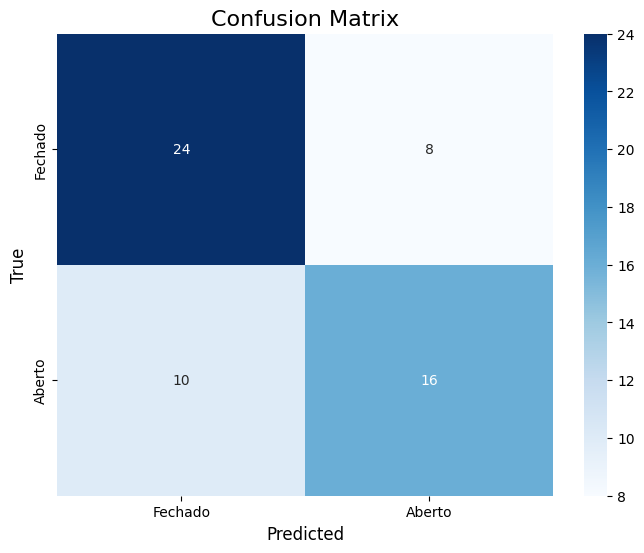

-------------------- Fold 5 --------------------
Epoch 1/100
29/29 [==============================] - 3s 7ms/step - loss: 0.8369 - accuracy: 0.5043
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.8092 - accuracy: 0.5086
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.7361 - accuracy: 0.5647
Epoch 4/100
29/29 [==============================] - 0s 8ms/step - loss: 0.7007 - accuracy: 0.6250
Epoch 5/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6527 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6774 - accuracy: 0.6078
Epoch 7/100
29/29 [==============================] - 0s 10ms/step - loss: 0.5599 - accuracy: 0.7328
Epoch 8/100
29/29 [==============================] - 0s 8ms/step - loss: 0.5903 - accuracy: 0.7069
Epoch 9/100
29/29 [==============================] - 0s 9ms/step - loss: 0.5174 - accuracy: 0.7371
Epoch 10/100
29/29 [==============================] - 0s 9m

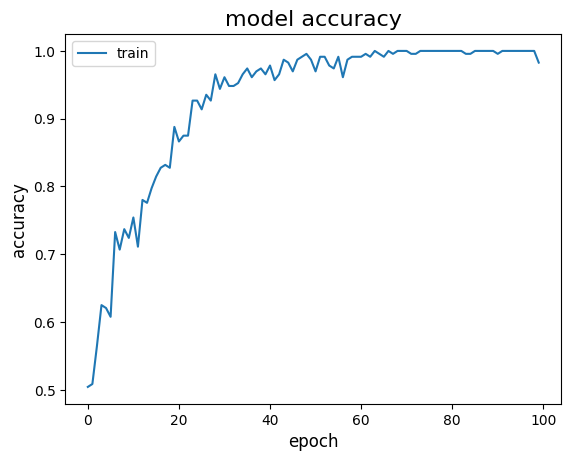

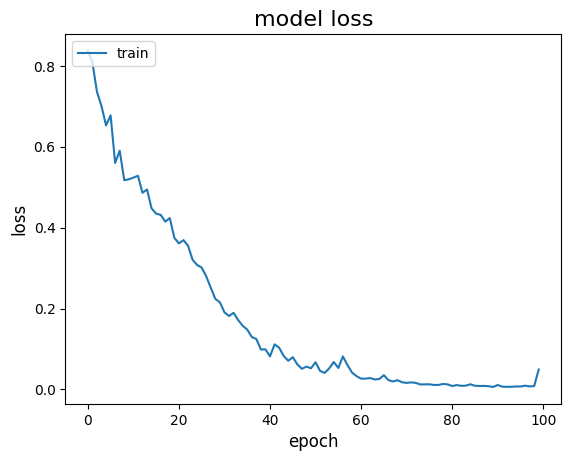

2/2 [==============================] - 0s 14ms/step
Accuracy: 0.793
F1 score: 0.76
Precision: 0.792
Recall: 0.731

 PERFORMANCE CNN - LSTM + Features
              precision    recall  f1-score   support

           0       0.79      0.84      0.82        32
           1       0.79      0.73      0.76        26

    accuracy                           0.79        58
   macro avg       0.79      0.79      0.79        58
weighted avg       0.79      0.79      0.79        58



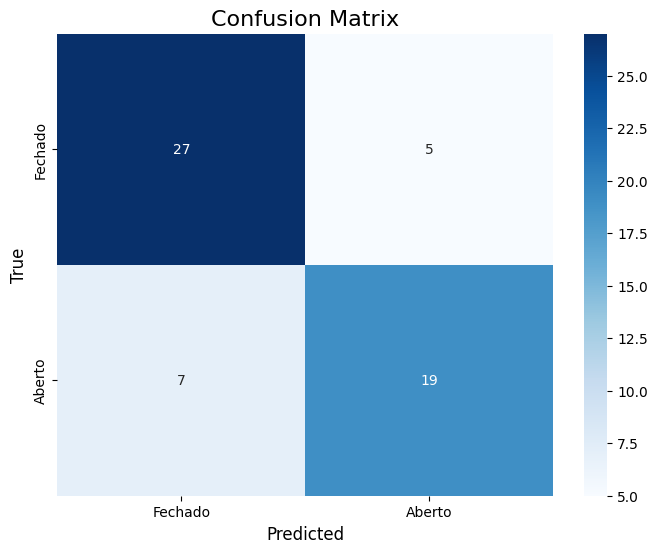

In [ ]:
# Lista para armazenar os resultados de cada fold
accuracy_CNN_LSTM_All_Features = []
f1_score_CNN_LSTM_All_Features = []


skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

n_features = X.shape[1] * 22 # Quantidade de features extraidas dos sinais

fold = 1
for train_index, test_index  in skfolds.split(X, y):
    print(f'-------------------- Fold {fold} --------------------')
    keras.backend.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    tf.keras.utils.set_random_seed(SEED)

    input_B = tf.keras.layers.Input(shape=[n_features], name='features_input')
    input_A = tf.keras.layers.Input(shape=[50, 14], name='timeseries_input')

    hidden_layer1 = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(input_A)
    hidden_layer2 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(hidden_layer1)
    max_pooling_layer = tf.keras.layers.MaxPooling1D(pool_size=2)(hidden_layer2)
    droopout_layer1 = tf.keras.layers.Dropout(0.2)(max_pooling_layer)
    hidden_layer3 = tf.keras.layers.Conv1D(filters=128, kernel_size=13, activation='relu')(droopout_layer1)
    hidden_layer4 = tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu')(hidden_layer3)
    hidden_layer5 = tf.keras.layers.LSTM(32, return_sequences=True)(hidden_layer4)
    global_pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(hidden_layer5)
    flatten_layer = tf.keras.layers.Flatten()(global_pooling_layer)
    concat = tf.keras.layers.concatenate([flatten_layer, input_B])

    hidden_layer6 = tf.keras.layers.Dense(64, activation='relu')(concat)
    droopout_layer2 = tf.keras.layers.Dropout(0.2)(hidden_layer6)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(droopout_layer2)

    model = tf.keras.Model(inputs=[input_A, input_B], outputs=[output])

    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    X_train_eeg = X[train_index]
    X_train_channels = X[train_index]
    y_train = y[train_index]

    X_test_eeg = X[test_index]
    X_test_channels = X[test_index]
    y_test = y[test_index]

    # Reshape nio formato que o tensorflow aceita
    X_train_eeg = X_train_eeg.reshape(X_train_eeg.shape[0], X_train_eeg.shape[2], X_train_eeg.shape[1])
    X_test_eeg = X_test_eeg.reshape(X_test_eeg.shape[0], X_test_eeg.shape[2], X_test_eeg.shape[1])

    # Scale the eeg signals
    sdt_scale_eeg_signals = StandardScaler()
    X_train_eeg = sdt_scale_eeg_signals.fit_transform(X_train_eeg.reshape(-1, X_train_eeg.shape[-1])).reshape(X_train_eeg.shape)
    X_test_eeg = sdt_scale_eeg_signals.transform(X_test_eeg.reshape(-1, X_test_eeg.shape[-1])).reshape(X_test_eeg.shape)

    # Scale the eeg channels to uses in catch22
    sdt_scale_eeg_channels = StandardScaler()
    X_train_channels = sdt_scale_eeg_channels.fit_transform(X_train_channels.reshape(-1, X_train_channels.shape[-1])).reshape(X_train_channels.shape)
    X_test_channels = sdt_scale_eeg_channels.transform(X_test_channels.reshape(-1, X_test_channels.shape[-1])).reshape(X_test_channels.shape)

    # Aplica o catch22 no X_train_features
    c22 = Catch22()
    X_train_features = c22.fit_transform(X_train_channels)
    X_test_features = c22.transform(X_test_channels)

    # Normaliza as features
    sdt_scale_features = StandardScaler()
    X_train_features = sdt_scale_features.fit_transform(X_train_features.reshape(-1, X_train_features.shape[-1])).reshape(X_train_features.shape)
    X_test_features = sdt_scale_features.transform(X_test_features.reshape(-1, X_test_features.shape[-1])).reshape(X_test_features.shape)


    history = model.fit([X_train_eeg, X_train_features], y_train, epochs=epochs, batch_size=batch_size)

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()


    predict = model.predict([X_test_eeg, X_test_features])
    predict[predict > 0.5] = 1
    predict[predict < 0.5] = 0

    accuracy,  f1_, _, _ =metrics(y_test, predict)
    accuracy_CNN_LSTM_All_Features.append(accuracy)
    f1_score_CNN_LSTM_All_Features.append(f1_)

    print(f'\n PERFORMANCE CNN - LSTM + Features')
    print(classification_report(y_test, predict))

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predict)

    # Get class labels from the dataset
    class_names = ['Fechado', 'Aberto']

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    fold += 1

In [ ]:
print('Performance do modelo CNN + LSTM + Features de todos os canais (mean and std)')
print(f'Accuracy: {round(np.mean(accuracy_CNN_LSTM_All_Features), 3)} +/- {round(np.std(accuracy_CNN_LSTM_All_Features), 3)}')
print(f'F1 score (macro): {round(np.mean(f1_score_CNN_LSTM_All_Features), 3)} +/- {round(np.std(f1_score_CNN_LSTM_All_Features), 3)}')

Performance do modelo CNN + LSTM + Features de todos os canais (mean and std)
Accuracy: 0.748 +/- 0.048
F1 score (macro): 0.718 +/- 0.054


# CNN - LSTM + Features dos canais O1 e O2

-------------------- Fold 1 --------------------
Epoch 1/100
29/29 [==============================] - 3s 9ms/step - loss: 0.8709 - accuracy: 0.4957
Epoch 2/100
29/29 [==============================] - 0s 9ms/step - loss: 0.8427 - accuracy: 0.4957
Epoch 3/100
29/29 [==============================] - 0s 8ms/step - loss: 0.7963 - accuracy: 0.5043
Epoch 4/100
29/29 [==============================] - 0s 8ms/step - loss: 0.7693 - accuracy: 0.5431
Epoch 5/100
29/29 [==============================] - 0s 8ms/step - loss: 0.7330 - accuracy: 0.5690
Epoch 6/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.6121
Epoch 7/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6732 - accuracy: 0.6164
Epoch 8/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6449 - accuracy: 0.6509
Epoch 9/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6514 - accuracy: 0.6336
Epoch 10/100
29/29 [==============================] - 0s 8ms

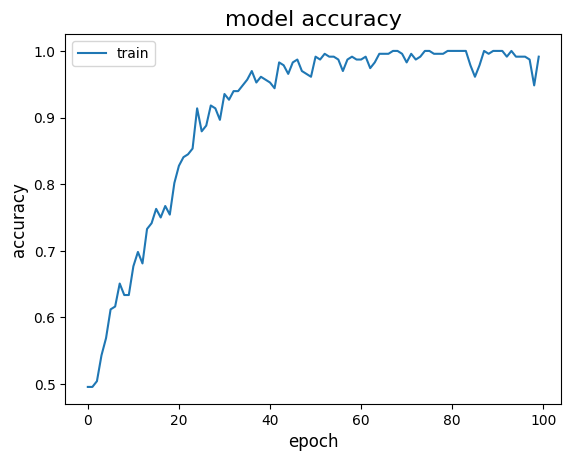

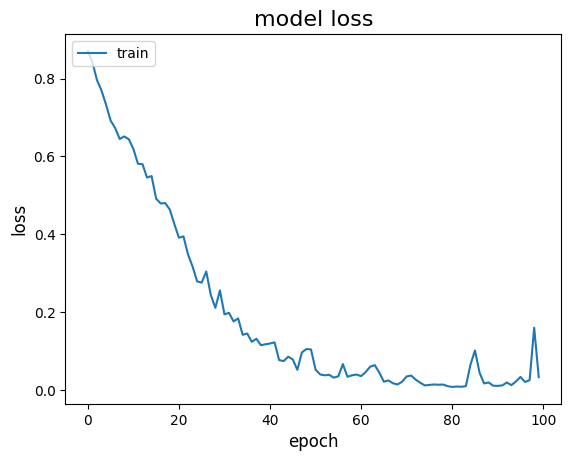

2/2 [==============================] - 1s 10ms/step
Accuracy: 0.741
F1 score: 0.706
Precision: 0.72
Recall: 0.692

 PERFORMANCE CNN - LSTM + Features
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        32
           1       0.72      0.69      0.71        26

    accuracy                           0.74        58
   macro avg       0.74      0.74      0.74        58
weighted avg       0.74      0.74      0.74        58



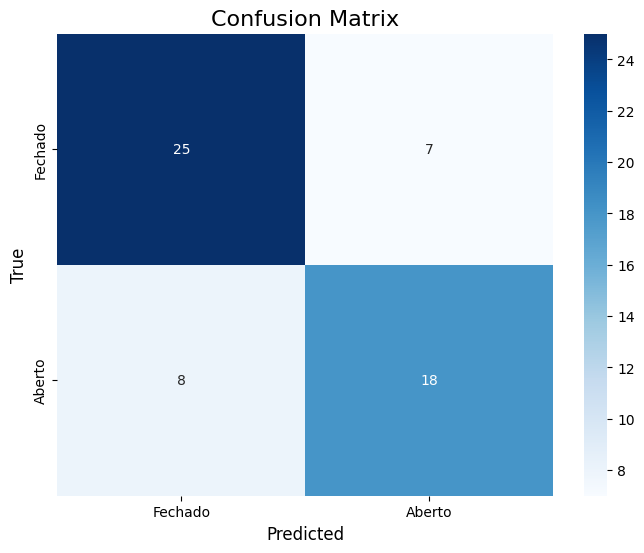

-------------------- Fold 2 --------------------
Epoch 1/100
29/29 [==============================] - 9s 10ms/step - loss: 0.8990 - accuracy: 0.4181
Epoch 2/100
29/29 [==============================] - 0s 11ms/step - loss: 0.8656 - accuracy: 0.4612
Epoch 3/100
29/29 [==============================] - 0s 11ms/step - loss: 0.8022 - accuracy: 0.4784
Epoch 4/100
29/29 [==============================] - 0s 9ms/step - loss: 0.7478 - accuracy: 0.4914
Epoch 5/100
29/29 [==============================] - 0s 12ms/step - loss: 0.7481 - accuracy: 0.5560
Epoch 6/100
29/29 [==============================] - 0s 11ms/step - loss: 0.7518 - accuracy: 0.5647
Epoch 7/100
29/29 [==============================] - 0s 10ms/step - loss: 0.7238 - accuracy: 0.5733
Epoch 8/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6902 - accuracy: 0.6121
Epoch 9/100
29/29 [==============================] - 0s 10ms/step - loss: 0.6632 - accuracy: 0.6336
Epoch 10/100
29/29 [==============================] -

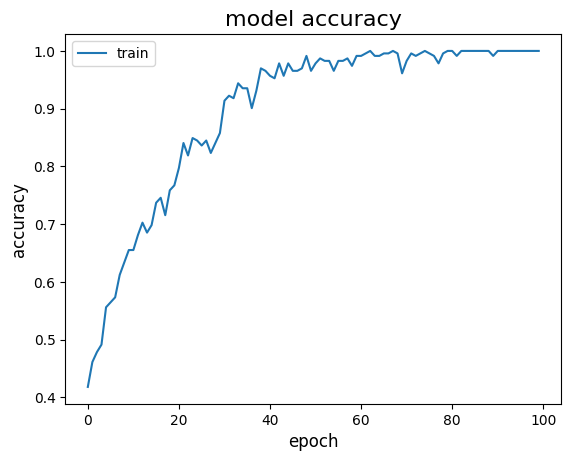

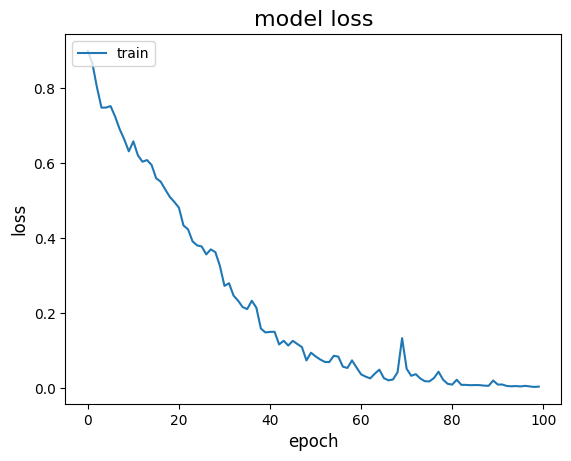

2/2 [==============================] - 0s 12ms/step
Accuracy: 0.672
F1 score: 0.642
Precision: 0.63
Recall: 0.654

 PERFORMANCE CNN - LSTM + Features
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        32
           1       0.63      0.65      0.64        26

    accuracy                           0.67        58
   macro avg       0.67      0.67      0.67        58
weighted avg       0.67      0.67      0.67        58



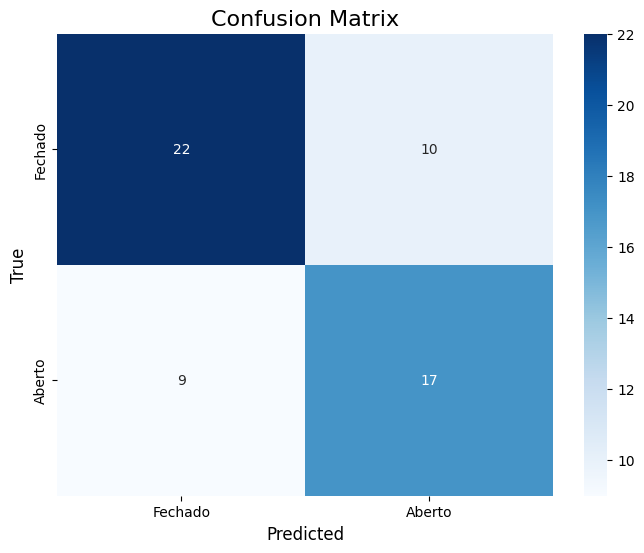

-------------------- Fold 3 --------------------
Epoch 1/100
29/29 [==============================] - 3s 7ms/step - loss: 0.8688 - accuracy: 0.4526
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.8382 - accuracy: 0.4526
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.7930 - accuracy: 0.5129
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.7613 - accuracy: 0.5129
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.7412 - accuracy: 0.5517
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.7197 - accuracy: 0.5819
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6739 - accuracy: 0.6207
Epoch 8/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6802 - accuracy: 0.5862
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6276 - accuracy: 0.6767
Epoch 10/100
29/29 [==============================] - 0s 7ms

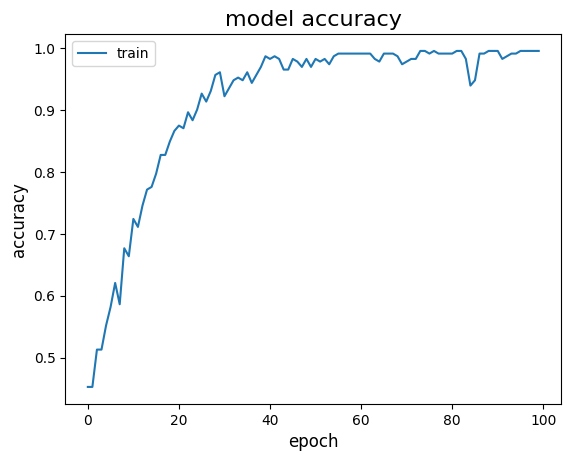

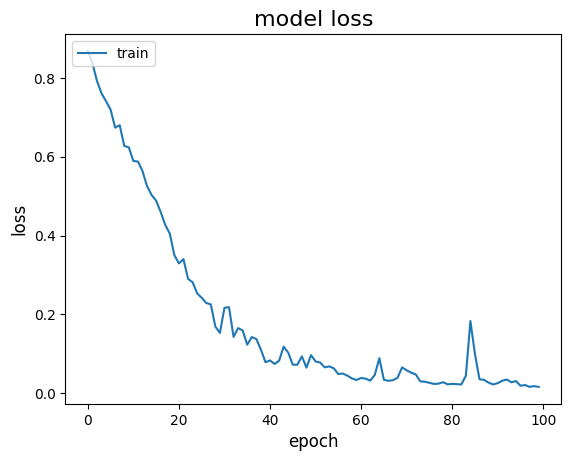

2/2 [==============================] - 0s 9ms/step
Accuracy: 0.724
F1 score: 0.692
Precision: 0.692
Recall: 0.692

 PERFORMANCE CNN - LSTM + Features
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        32
           1       0.69      0.69      0.69        26

    accuracy                           0.72        58
   macro avg       0.72      0.72      0.72        58
weighted avg       0.72      0.72      0.72        58



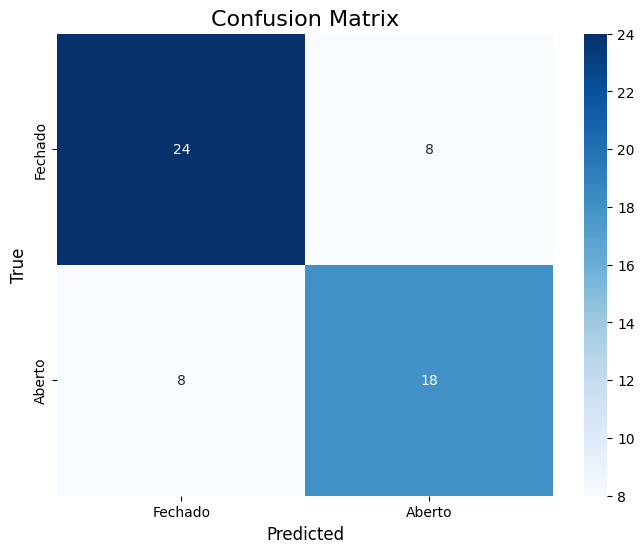

-------------------- Fold 4 --------------------
Epoch 1/100
29/29 [==============================] - 11s 14ms/step - loss: 0.8676 - accuracy: 0.4310
Epoch 2/100
29/29 [==============================] - 0s 13ms/step - loss: 0.8561 - accuracy: 0.4526
Epoch 3/100
29/29 [==============================] - 0s 14ms/step - loss: 0.8186 - accuracy: 0.4698
Epoch 4/100
29/29 [==============================] - 0s 13ms/step - loss: 0.7531 - accuracy: 0.4871
Epoch 5/100
29/29 [==============================] - 0s 15ms/step - loss: 0.7642 - accuracy: 0.5259
Epoch 6/100
29/29 [==============================] - 0s 12ms/step - loss: 0.7608 - accuracy: 0.5129
Epoch 7/100
29/29 [==============================] - 0s 13ms/step - loss: 0.7356 - accuracy: 0.5733
Epoch 8/100
29/29 [==============================] - 1s 20ms/step - loss: 0.7375 - accuracy: 0.5474
Epoch 9/100
29/29 [==============================] - 0s 16ms/step - loss: 0.7059 - accuracy: 0.5776
Epoch 10/100
29/29 [==============================

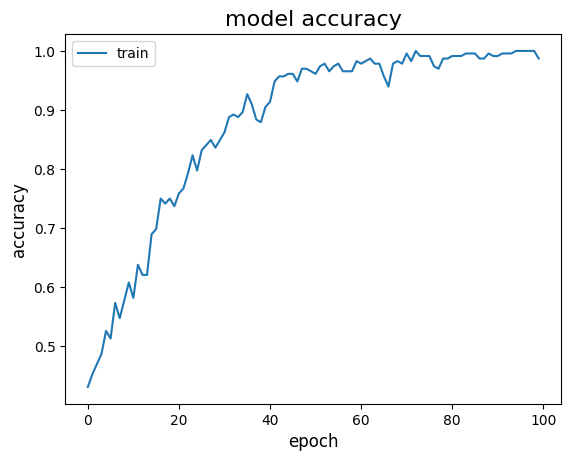

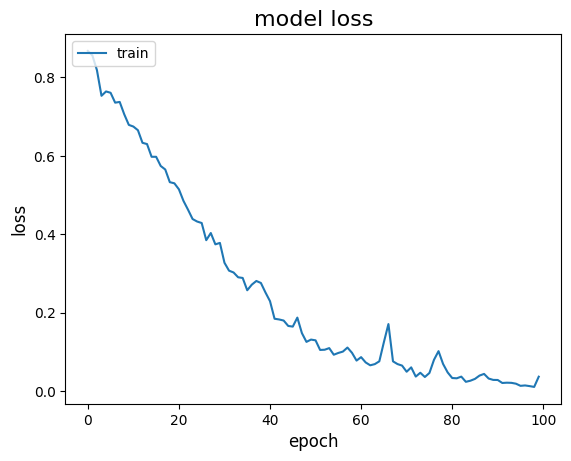

2/2 [==============================] - 0s 11ms/step
Accuracy: 0.69
F1 score: 0.609
Precision: 0.7
Recall: 0.538

 PERFORMANCE CNN - LSTM + Features
              precision    recall  f1-score   support

           0       0.68      0.81      0.74        32
           1       0.70      0.54      0.61        26

    accuracy                           0.69        58
   macro avg       0.69      0.68      0.68        58
weighted avg       0.69      0.69      0.68        58



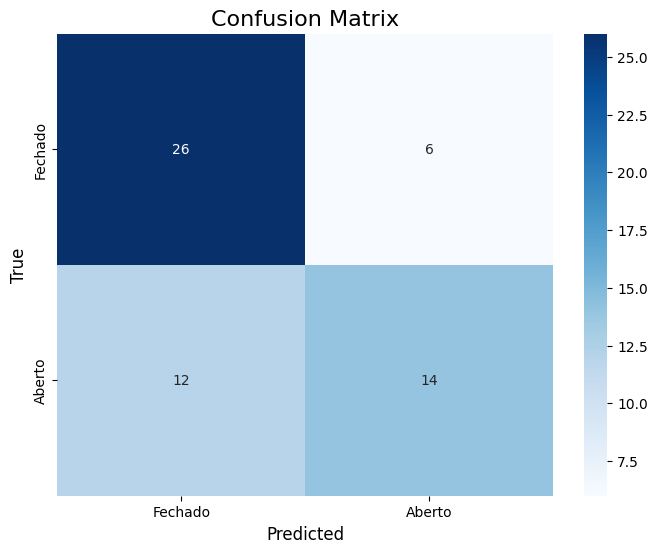

-------------------- Fold 5 --------------------
Epoch 1/100
29/29 [==============================] - 4s 10ms/step - loss: 0.8219 - accuracy: 0.4526
Epoch 2/100
29/29 [==============================] - 0s 9ms/step - loss: 0.8137 - accuracy: 0.4655
Epoch 3/100
29/29 [==============================] - 0s 9ms/step - loss: 0.7773 - accuracy: 0.4871
Epoch 4/100
29/29 [==============================] - 0s 9ms/step - loss: 0.7327 - accuracy: 0.5259
Epoch 5/100
29/29 [==============================] - 0s 8ms/step - loss: 0.7133 - accuracy: 0.5388
Epoch 6/100
29/29 [==============================] - 0s 9ms/step - loss: 0.7095 - accuracy: 0.5647
Epoch 7/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6684 - accuracy: 0.5819
Epoch 8/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6464 - accuracy: 0.6078
Epoch 9/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6603 - accuracy: 0.6379
Epoch 10/100
29/29 [==============================] - 0s 9m

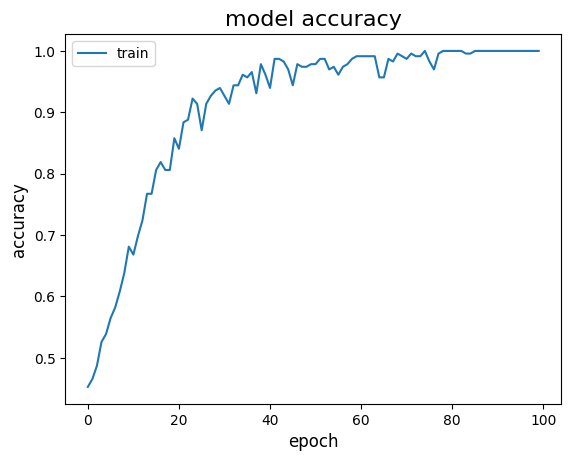

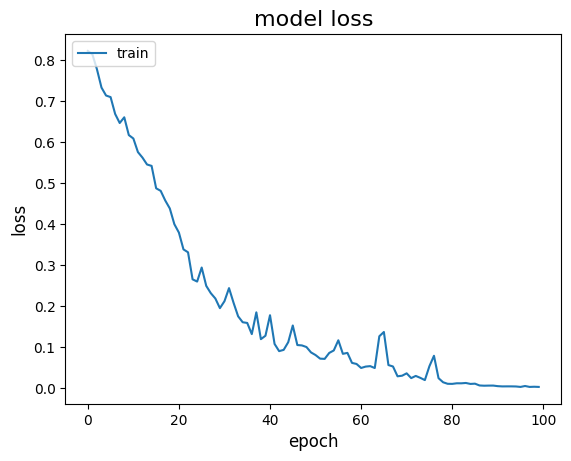

2/2 [==============================] - 1s 13ms/step
Accuracy: 0.81
F1 score: 0.784
Precision: 0.8
Recall: 0.769

 PERFORMANCE CNN - LSTM + Features
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.80      0.77      0.78        26

    accuracy                           0.81        58
   macro avg       0.81      0.81      0.81        58
weighted avg       0.81      0.81      0.81        58



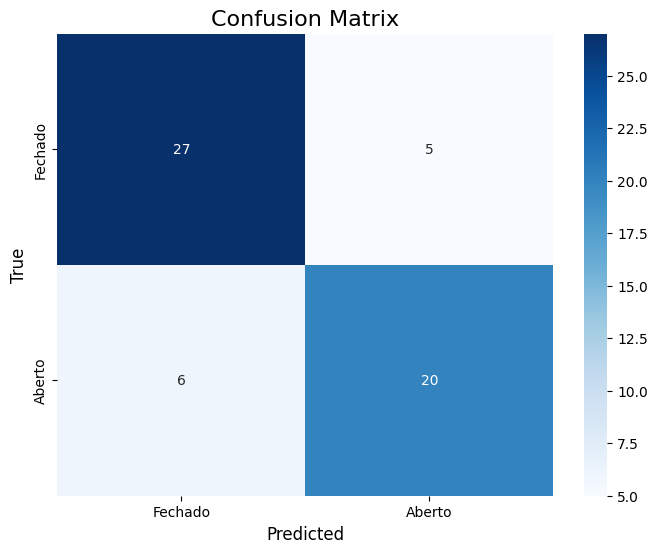

In [ ]:
# Lista para armazenar os resultados de cada fold
accuracy_CNN_LSTM_Features_From_O1_O2 = []
f1_score_CNN_LSTM_Features_From_O1_O2 = []


skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

n_features = X_channels.shape[1] * 22 # Quantidade de features extraidas dos sinais

fold = 1
for train_index, test_index  in skfolds.split(X, y):
    print(f'-------------------- Fold {fold} --------------------')
    keras.backend.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    tf.keras.utils.set_random_seed(SEED)

    input_B = tf.keras.layers.Input(shape=[n_features], name='features_input')
    input_A = tf.keras.layers.Input(shape=[50, 14], name='timeseries_input')

    hidden_layer1 = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(input_A)
    hidden_layer2 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(hidden_layer1)
    max_pooling_layer = tf.keras.layers.MaxPooling1D(pool_size=2)(hidden_layer2)
    droopout_layer1 = tf.keras.layers.Dropout(0.2)(max_pooling_layer)
    hidden_layer3 = tf.keras.layers.Conv1D(filters=128, kernel_size=13, activation='relu')(droopout_layer1)
    hidden_layer4 = tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu')(hidden_layer3)
    hidden_layer5 = tf.keras.layers.LSTM(32, return_sequences=True)(hidden_layer4)
    global_pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(hidden_layer5)
    flatten_layer = tf.keras.layers.Flatten()(global_pooling_layer)
    concat = tf.keras.layers.concatenate([flatten_layer, input_B])

    hidden_layer6 = tf.keras.layers.Dense(64, activation='relu')(concat)
    droopout_layer2 = tf.keras.layers.Dropout(0.2)(hidden_layer6)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(droopout_layer2)

    model = tf.keras.Model(inputs=[input_A, input_B], outputs=[output])

    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    X_train_eeg = X[train_index]
    X_train_channels = X_channels[train_index]
    y_train = y[train_index]

    X_test_eeg = X[test_index]
    X_test_channels = X_channels[test_index]
    y_test = y[test_index]

    # Reshape nio formato que o tensorflow aceita
    X_train_eeg = X_train_eeg.reshape(X_train_eeg.shape[0], X_train_eeg.shape[2], X_train_eeg.shape[1])
    X_test_eeg = X_test_eeg.reshape(X_test_eeg.shape[0], X_test_eeg.shape[2], X_test_eeg.shape[1])

    # Scale the eeg signals
    sdt_scale_eeg_signals = StandardScaler()
    X_train_eeg = sdt_scale_eeg_signals.fit_transform(X_train_eeg.reshape(-1, X_train_eeg.shape[-1])).reshape(X_train_eeg.shape)
    X_test_eeg = sdt_scale_eeg_signals.transform(X_test_eeg.reshape(-1, X_test_eeg.shape[-1])).reshape(X_test_eeg.shape)

    # Scale the eeg channels to uses in catch22
    sdt_scale_eeg_channels = StandardScaler()
    X_train_channels = sdt_scale_eeg_channels.fit_transform(X_train_channels.reshape(-1, X_train_channels.shape[-1])).reshape(X_train_channels.shape)
    X_test_channels = sdt_scale_eeg_channels.transform(X_test_channels.reshape(-1, X_test_channels.shape[-1])).reshape(X_test_channels.shape)

    # Aplica o catch22 no X_train_features
    c22 = Catch22()
    X_train_features = c22.fit_transform(X_train_channels)
    X_test_features = c22.transform(X_test_channels)

    # Normaliza as features
    sdt_scale_features = StandardScaler()
    X_train_features = sdt_scale_features.fit_transform(X_train_features.reshape(-1, X_train_features.shape[-1])).reshape(X_train_features.shape)
    X_test_features = sdt_scale_features.transform(X_test_features.reshape(-1, X_test_features.shape[-1])).reshape(X_test_features.shape)


    history = model.fit([X_train_eeg, X_train_features], y_train, epochs=epochs, batch_size=batch_size)

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()


    predict = model.predict([X_test_eeg, X_test_features])
    predict[predict > 0.5] = 1
    predict[predict < 0.5] = 0

    accuracy,  f1_, _, _ =metrics(y_test, predict)
    accuracy_CNN_LSTM_Features_From_O1_O2.append(accuracy)
    f1_score_CNN_LSTM_Features_From_O1_O2.append(f1_)

    print(f'\n PERFORMANCE CNN - LSTM + Features')
    print(classification_report(y_test, predict))

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predict)

    # Get class labels from the dataset
    class_names = ['Fechado', 'Aberto']

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    fold += 1

In [ ]:
print('Performance do modelo CNN + LSTM + Features dos canais O1 e O2 (mean and std)')
print(f'Accuracy: {round(np.mean(accuracy_CNN_LSTM_Features_From_O1_O2), 3)} +/- {round(np.std(accuracy_CNN_LSTM_Features_From_O1_O2), 3)}')
print(f'F1 score (macro): {round(np.mean(f1_score_CNN_LSTM_Features_From_O1_O2), 3)} +/- {round(np.std(f1_score_CNN_LSTM_Features_From_O1_O2), 3)}')

Performance do modelo CNN + LSTM + Features dos canais O1 e O2 (mean and std)
Accuracy: 0.727 +/- 0.048
F1 score (macro): 0.687 +/- 0.06


# CNN - LSTM

-------------------- Fold 1 --------------------
Epoch 1/100
29/29 [==============================] - 4s 6ms/step - loss: 0.6927 - accuracy: 0.5086
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6861 - accuracy: 0.6078
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6770 - accuracy: 0.6293
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6687 - accuracy: 0.6250
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6547 - accuracy: 0.6509
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6391 - accuracy: 0.6681
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6206 - accuracy: 0.6810
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6019 - accuracy: 0.7069
Epoch 9/100
29/29 [==============================] - 0s 6ms/step - loss: 0.5838 - accuracy: 0.7241
Epoch 10/100
29/29 [==============================] - 0s 6ms

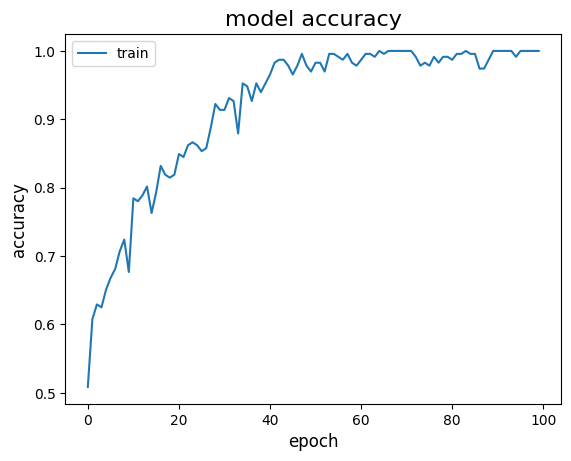

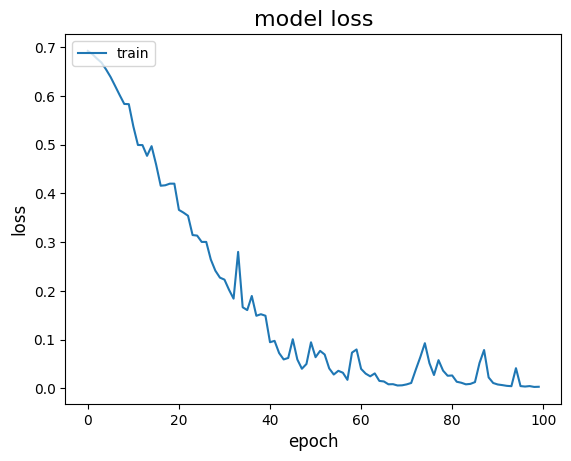

2/2 [==============================] - 0s 9ms/step
Accuracy: 0.707
F1 score: 0.691
Precision: 0.655
Recall: 0.731

 PERFORMANCE CNN - LSTM
              precision    recall  f1-score   support

           0       0.76      0.69      0.72        32
           1       0.66      0.73      0.69        26

    accuracy                           0.71        58
   macro avg       0.71      0.71      0.71        58
weighted avg       0.71      0.71      0.71        58



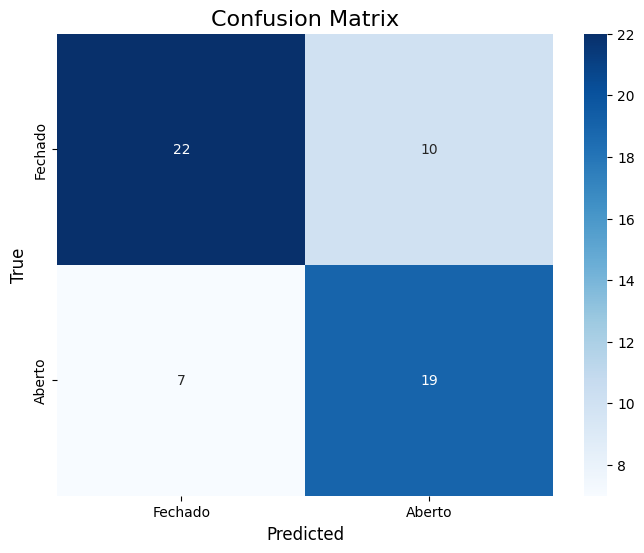

-------------------- Fold 2 --------------------
Epoch 1/100
29/29 [==============================] - 3s 7ms/step - loss: 0.6929 - accuracy: 0.5216
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5560
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6838 - accuracy: 0.5948
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6796 - accuracy: 0.5862
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6705 - accuracy: 0.5948
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6654 - accuracy: 0.6078
Epoch 7/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6511 - accuracy: 0.5991
Epoch 8/100
29/29 [==============================] - 0s 9ms/step - loss: 0.6355 - accuracy: 0.6466
Epoch 9/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6331 - accuracy: 0.6509
Epoch 10/100
29/29 [==============================] - 0s 9ms

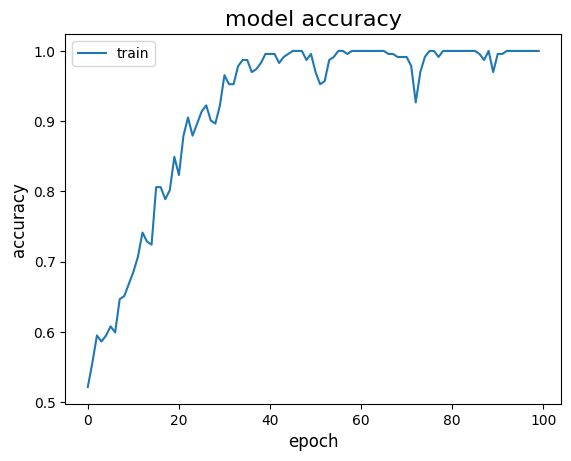

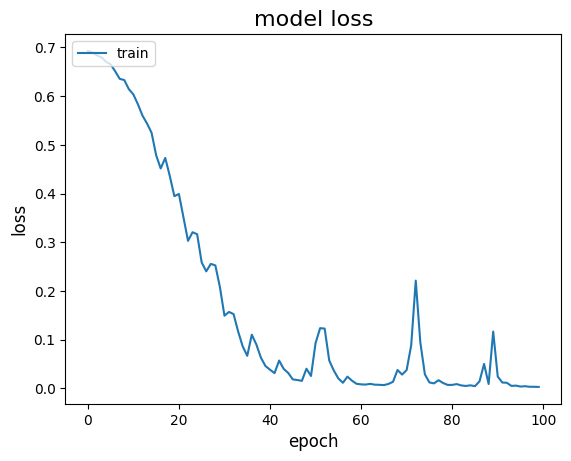

2/2 [==============================] - 0s 14ms/step
Accuracy: 0.69
F1 score: 0.667
Precision: 0.643
Recall: 0.692

 PERFORMANCE CNN - LSTM
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        32
           1       0.64      0.69      0.67        26

    accuracy                           0.69        58
   macro avg       0.69      0.69      0.69        58
weighted avg       0.69      0.69      0.69        58



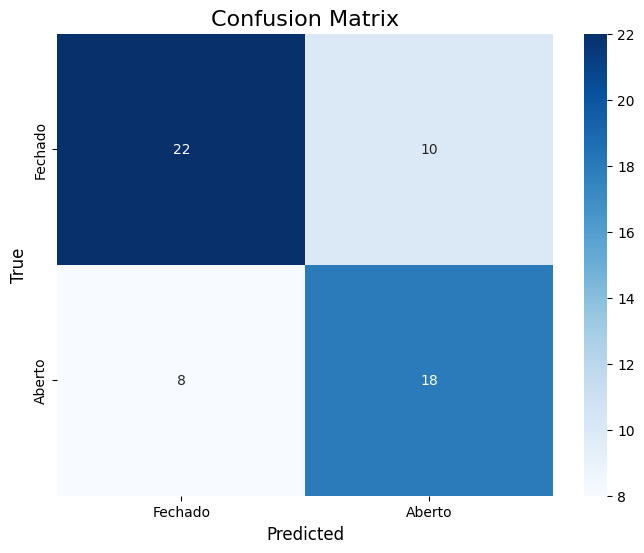

-------------------- Fold 3 --------------------
Epoch 1/100
29/29 [==============================] - 3s 7ms/step - loss: 0.6922 - accuracy: 0.5690
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6897 - accuracy: 0.5690
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6835 - accuracy: 0.6078
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6743 - accuracy: 0.6078
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6577 - accuracy: 0.6422
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6437 - accuracy: 0.6466
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6121 - accuracy: 0.7198
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 0.5809 - accuracy: 0.7457
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.5533 - accuracy: 0.7543
Epoch 10/100
29/29 [==============================] - 0s 7ms

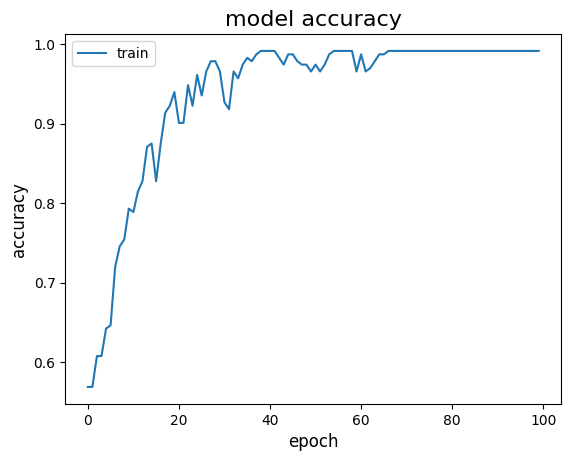

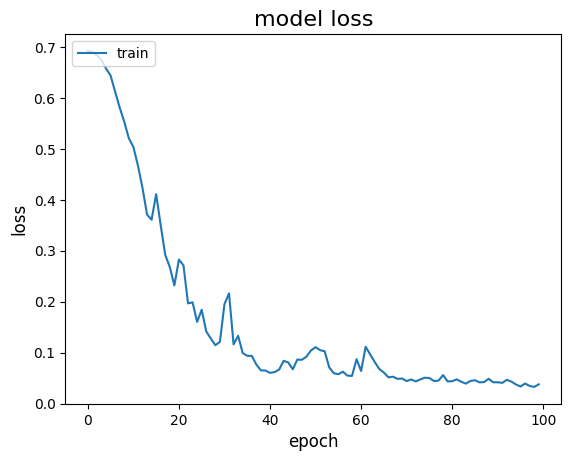

2/2 [==============================] - 0s 12ms/step
Accuracy: 0.776
F1 score: 0.745
Precision: 0.76
Recall: 0.731

 PERFORMANCE CNN - LSTM
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        32
           1       0.76      0.73      0.75        26

    accuracy                           0.78        58
   macro avg       0.77      0.77      0.77        58
weighted avg       0.78      0.78      0.78        58



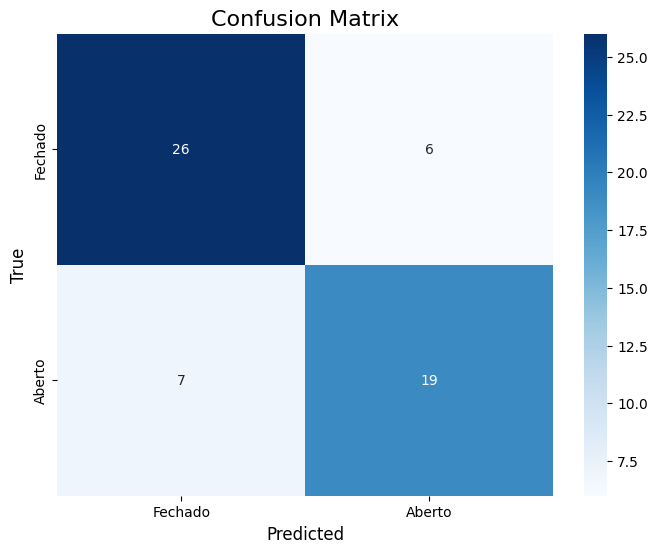

-------------------- Fold 4 --------------------
Epoch 1/100
29/29 [==============================] - 3s 7ms/step - loss: 0.6928 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5647
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6847 - accuracy: 0.5733
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6786 - accuracy: 0.5948
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6721 - accuracy: 0.5862
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6634 - accuracy: 0.5690
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6509 - accuracy: 0.6034
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6480 - accuracy: 0.6034
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6395 - accuracy: 0.6078
Epoch 10/100
29/29 [==============================] - 0s 7ms

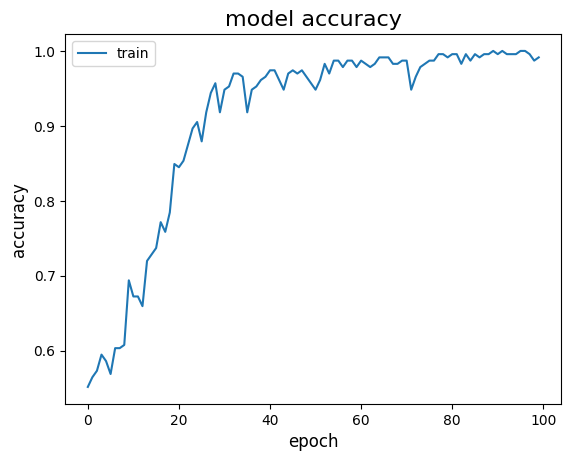

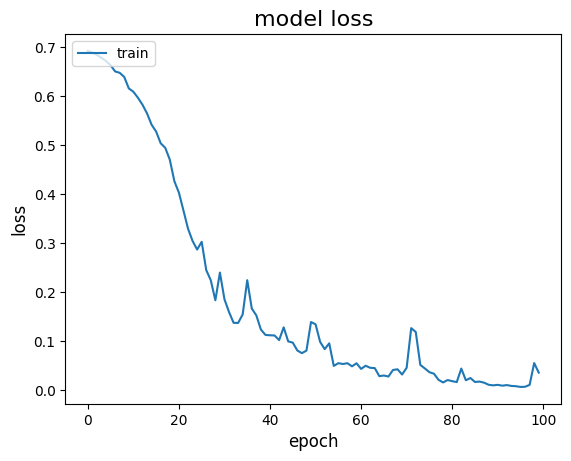

2/2 [==============================] - 0s 11ms/step
Accuracy: 0.672
F1 score: 0.612
Precision: 0.652
Recall: 0.577

 PERFORMANCE CNN - LSTM
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        32
           1       0.65      0.58      0.61        26

    accuracy                           0.67        58
   macro avg       0.67      0.66      0.66        58
weighted avg       0.67      0.67      0.67        58



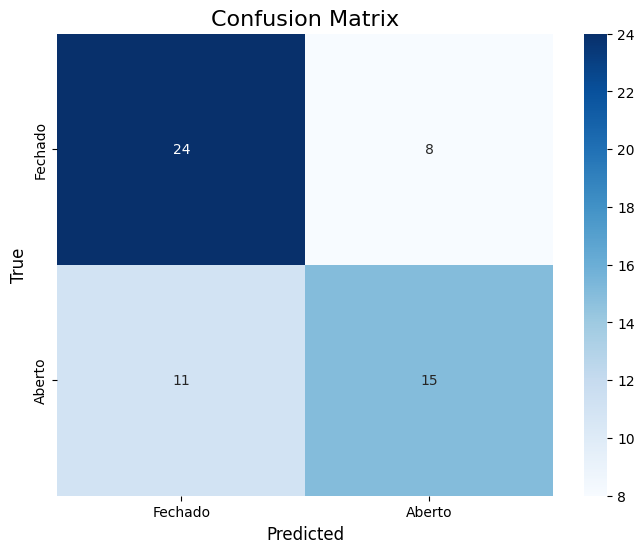

-------------------- Fold 5 --------------------
Epoch 1/100
29/29 [==============================] - 3s 7ms/step - loss: 0.6913 - accuracy: 0.5388
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6885 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6824 - accuracy: 0.6336
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6746 - accuracy: 0.6422
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6614 - accuracy: 0.6724
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6471 - accuracy: 0.6422
Epoch 7/100
29/29 [==============================] - 0s 10ms/step - loss: 0.6200 - accuracy: 0.6724
Epoch 8/100
29/29 [==============================] - 0s 9ms/step - loss: 0.5949 - accuracy: 0.7284
Epoch 9/100
29/29 [==============================] - 0s 9ms/step - loss: 0.5794 - accuracy: 0.7112
Epoch 10/100
29/29 [==============================] - 0s 9m

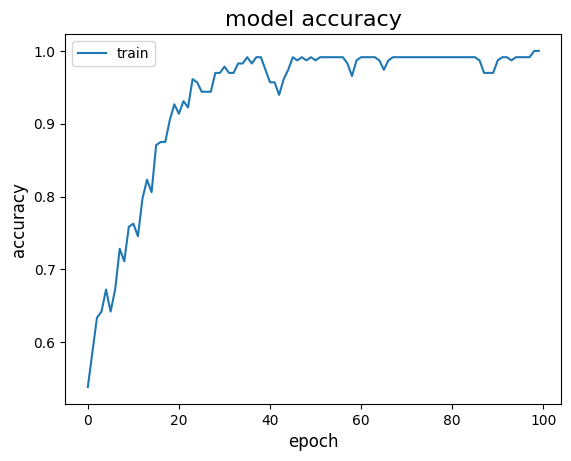

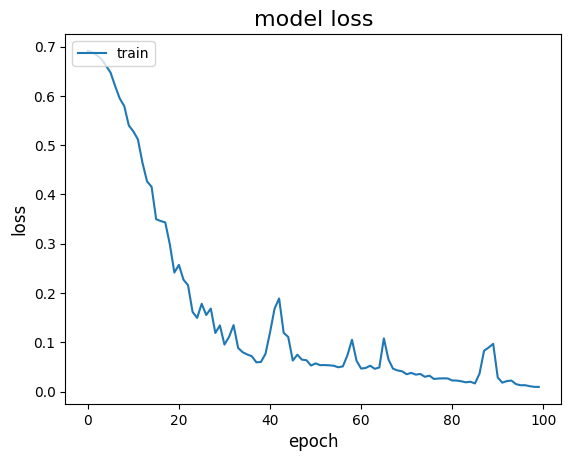

2/2 [==============================] - 0s 7ms/step
Accuracy: 0.776
F1 score: 0.735
Precision: 0.783
Recall: 0.692

 PERFORMANCE CNN - LSTM
              precision    recall  f1-score   support

           0       0.77      0.84      0.81        32
           1       0.78      0.69      0.73        26

    accuracy                           0.78        58
   macro avg       0.78      0.77      0.77        58
weighted avg       0.78      0.78      0.77        58



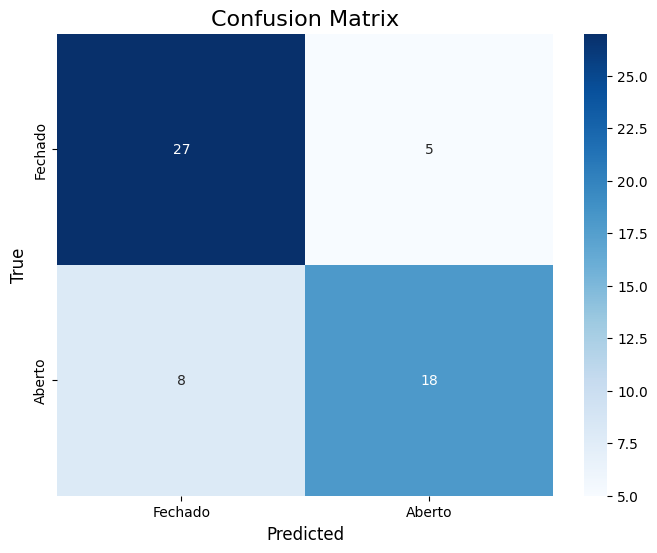

In [ ]:
# Lista para armazenar os resultados de cada fold
accuracy_CNN_LSTM = []
f1_score_CNN_LSTM = []


skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

n_features = X_channels.shape[1] * 22 # Quantidade de features extraidas dos sinais

fold = 1
for train_index, test_index  in skfolds.split(X, y):
    print(f'-------------------- Fold {fold} --------------------')
    keras.backend.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    tf.keras.utils.set_random_seed(SEED)

    model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[50, 14]),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=13, activation='relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    X_train_eeg = X[train_index]
    y_train = y[train_index]

    X_test_eeg = X[test_index]
    y_test = y[test_index]

    # Reshape no formato que o tensorflow aceita
    X_train_eeg = X_train_eeg.reshape(X_train_eeg.shape[0], X_train_eeg.shape[2], X_train_eeg.shape[1])
    X_test_eeg = X_test_eeg.reshape(X_test_eeg.shape[0], X_test_eeg.shape[2], X_test_eeg.shape[1])

    # Scale the eeg signals
    sdt_scale_eeg_signals = StandardScaler()
    X_train_eeg = sdt_scale_eeg_signals.fit_transform(X_train_eeg.reshape(-1, X_train_eeg.shape[-1])).reshape(X_train_eeg.shape)
    X_test_eeg = sdt_scale_eeg_signals.transform(X_test_eeg.reshape(-1, X_test_eeg.shape[-1])).reshape(X_test_eeg.shape)

    history = model.fit(X_train_eeg, y_train, epochs=epochs, batch_size=batch_size)

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()


    predict = model.predict(X_test_eeg)
    predict[predict > 0.5] = 1
    predict[predict < 0.5] = 0

    accuracy,  f1_, _, _ = metrics(y_test, predict)
    accuracy_CNN_LSTM.append(accuracy)
    f1_score_CNN_LSTM.append(f1_)

    print(f'\n PERFORMANCE CNN - LSTM')
    print(classification_report(y_test, predict))

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predict)

    # Get class labels from the dataset
    class_names = ['Fechado', 'Aberto']

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    fold += 1

In [ ]:
print('Performance do modelo CNN + LSTM (mean and std)')
print(f'Accuracy: {round(np.mean(accuracy_CNN_LSTM), 3)} +/- {round(np.std(accuracy_CNN_LSTM), 3)}')
print(f'F1 score (macro): {round(np.mean(f1_score_CNN_LSTM), 3)} +/- {round(np.std(f1_score_CNN_LSTM), 3)}')

Performance do modelo CNN + LSTM (mean and std)
Accuracy: 0.724 +/- 0.044
F1 score (macro): 0.69 +/- 0.048


# Multi Layer Perceptron (Usa as features extraidas de todos os canais como entrada)

-------------------- Fold 1 --------------------
Epoch 1/100
29/29 [==============================] - 1s 4ms/step - loss: 0.6777 - accuracy: 0.5905
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5906 - accuracy: 0.6638
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5441 - accuracy: 0.7241
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5069 - accuracy: 0.8017
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4741 - accuracy: 0.8147
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4448 - accuracy: 0.8491
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4190 - accuracy: 0.8750
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3962 - accuracy: 0.8879
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3751 - accuracy: 0.9009
Epoch 10/100
29/29 [==============================] - 0s 4ms

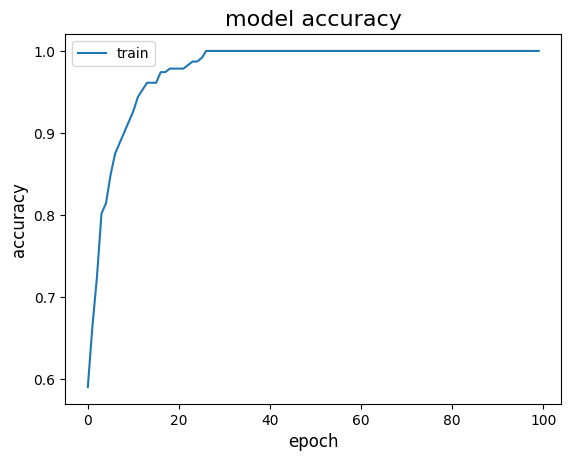

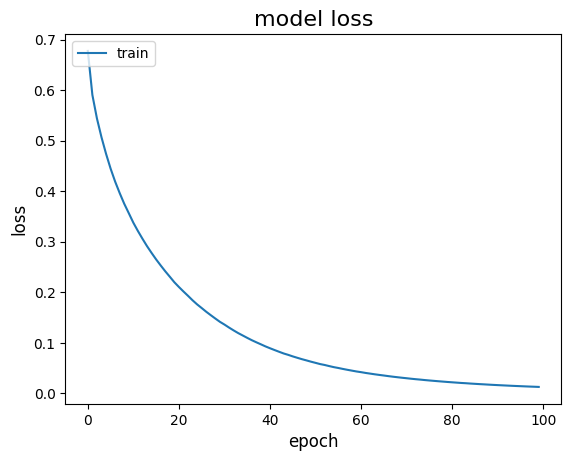

2/2 [==============================] - 0s 6ms/step
Accuracy: 0.655
F1 score: 0.565
Precision: 0.65
Recall: 0.5

 PERFORMANCE MLP
              precision    recall  f1-score   support

           0       0.66      0.78      0.71        32
           1       0.65      0.50      0.57        26

    accuracy                           0.66        58
   macro avg       0.65      0.64      0.64        58
weighted avg       0.65      0.66      0.65        58



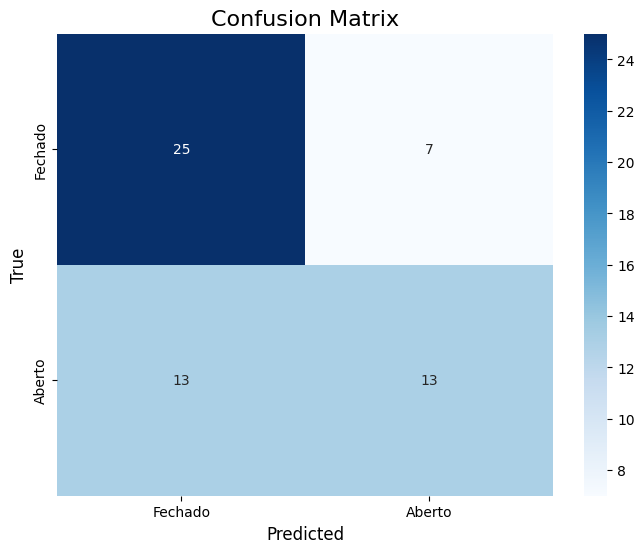

-------------------- Fold 2 --------------------
Epoch 1/100
29/29 [==============================] - 1s 3ms/step - loss: 0.6903 - accuracy: 0.5603
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5997 - accuracy: 0.6509
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5491 - accuracy: 0.7155
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5102 - accuracy: 0.7759
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4781 - accuracy: 0.8103
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4479 - accuracy: 0.8491
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4198 - accuracy: 0.8879
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3958 - accuracy: 0.9095
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3752 - accuracy: 0.9052
Epoch 10/100
29/29 [==============================] - 0s 3ms

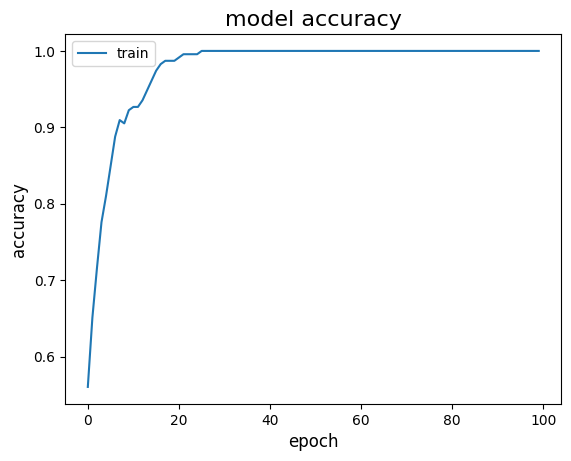

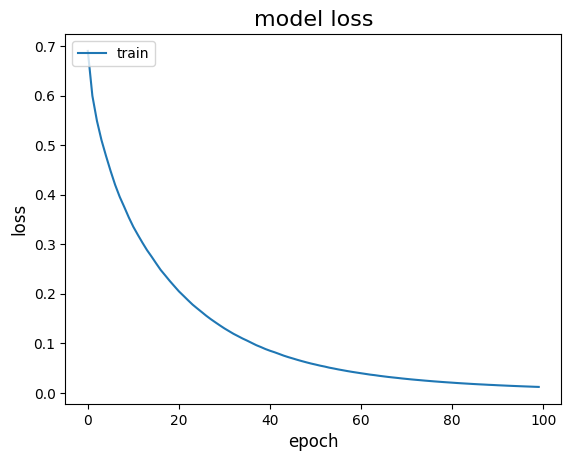

2/2 [==============================] - 0s 7ms/step
Accuracy: 0.672
F1 score: 0.642
Precision: 0.63
Recall: 0.654

 PERFORMANCE MLP
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        32
           1       0.63      0.65      0.64        26

    accuracy                           0.67        58
   macro avg       0.67      0.67      0.67        58
weighted avg       0.67      0.67      0.67        58



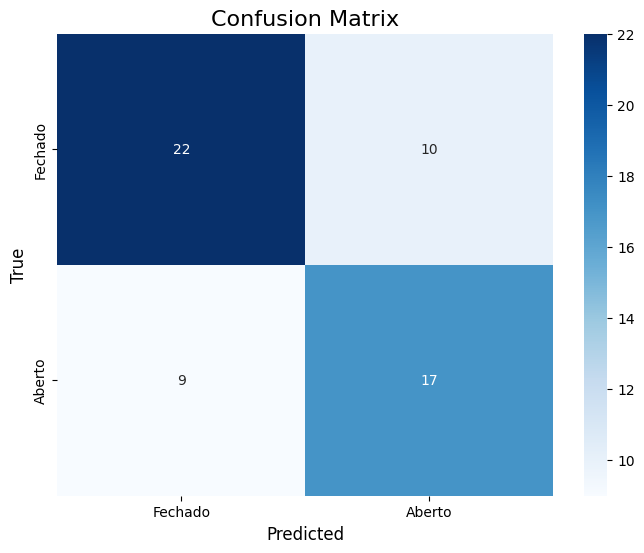

-------------------- Fold 3 --------------------
Epoch 1/100
29/29 [==============================] - 1s 3ms/step - loss: 0.6920 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6040 - accuracy: 0.6897
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5543 - accuracy: 0.7241
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5146 - accuracy: 0.7543
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4842 - accuracy: 0.7672
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4556 - accuracy: 0.8060
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4295 - accuracy: 0.8319
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4072 - accuracy: 0.8491
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3849 - accuracy: 0.8750
Epoch 10/100
29/29 [==============================] - 0s 3ms

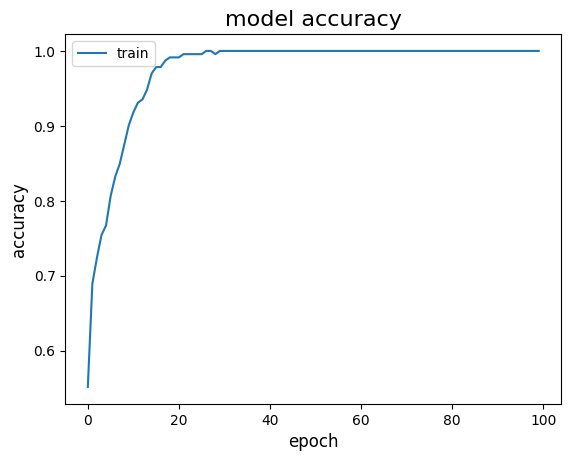

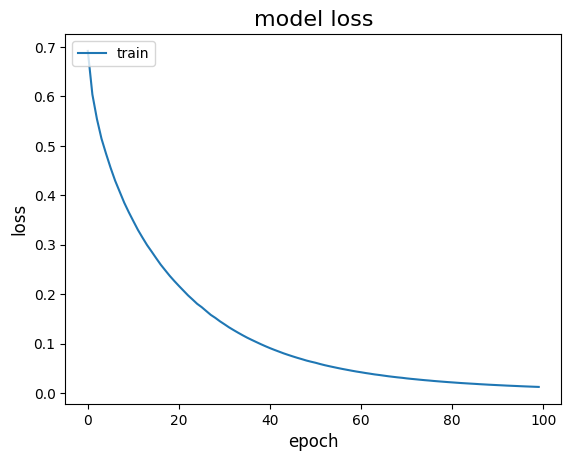

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.603
F1 score: 0.566
Precision: 0.556
Recall: 0.577

 PERFORMANCE MLP
              precision    recall  f1-score   support

           0       0.65      0.62      0.63        32
           1       0.56      0.58      0.57        26

    accuracy                           0.60        58
   macro avg       0.60      0.60      0.60        58
weighted avg       0.60      0.60      0.60        58



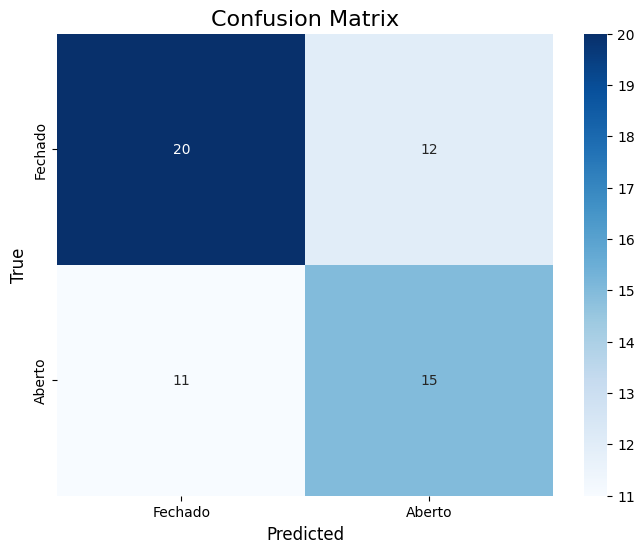

-------------------- Fold 4 --------------------
Epoch 1/100
29/29 [==============================] - 1s 3ms/step - loss: 0.7044 - accuracy: 0.5216
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6552
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5639 - accuracy: 0.7112
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5235 - accuracy: 0.7500
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4904 - accuracy: 0.7716
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.8190
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4335 - accuracy: 0.8664
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4103 - accuracy: 0.8879
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.3888 - accuracy: 0.9095
Epoch 10/100
29/29 [==============================] - 0s 3ms

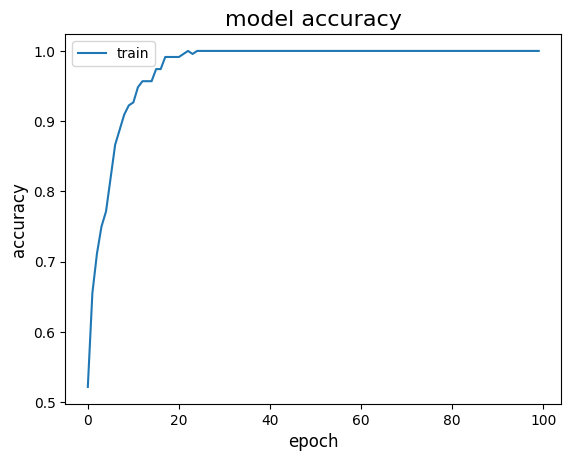

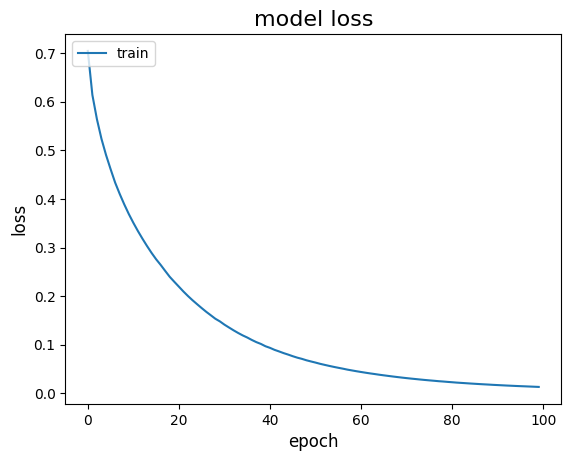

2/2 [==============================] - 0s 4ms/step
Accuracy: 0.672
F1 score: 0.596
Precision: 0.667
Recall: 0.538

 PERFORMANCE MLP
              precision    recall  f1-score   support

           0       0.68      0.78      0.72        32
           1       0.67      0.54      0.60        26

    accuracy                           0.67        58
   macro avg       0.67      0.66      0.66        58
weighted avg       0.67      0.67      0.67        58



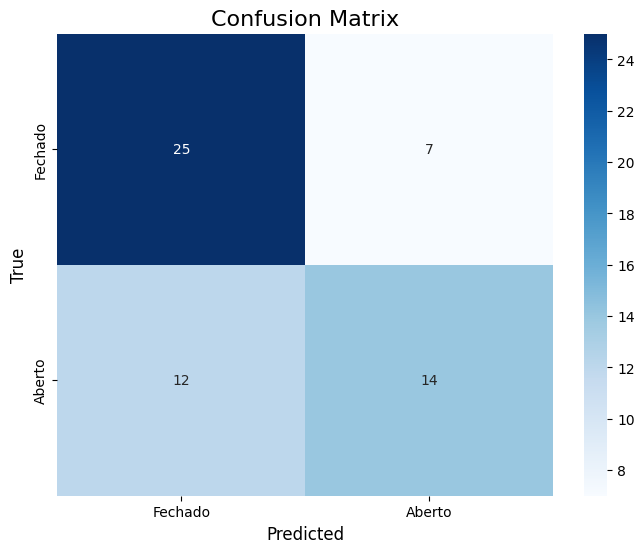

-------------------- Fold 5 --------------------
Epoch 1/100
29/29 [==============================] - 1s 5ms/step - loss: 0.7315 - accuracy: 0.5086
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6552
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5777 - accuracy: 0.6940
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5355 - accuracy: 0.7586
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5020 - accuracy: 0.8017
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4710 - accuracy: 0.8276
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4456 - accuracy: 0.8664
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4205 - accuracy: 0.8750
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3990 - accuracy: 0.9009
Epoch 10/100
29/29 [==============================] - 0s 4ms

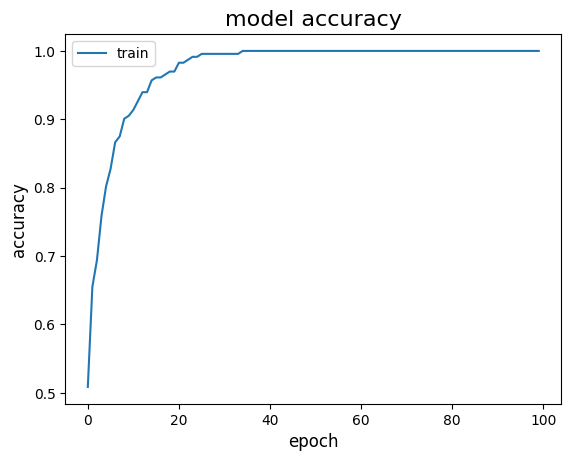

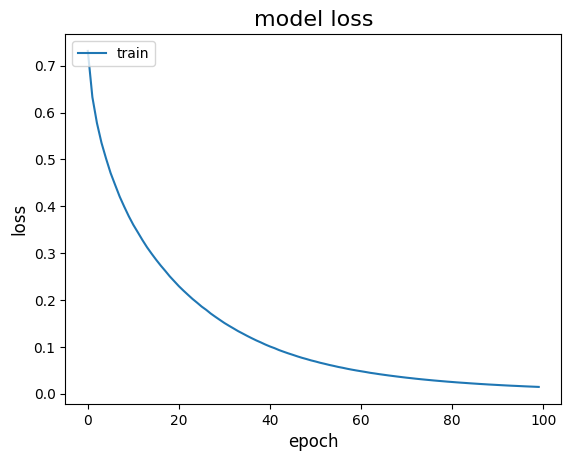

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.655
F1 score: 0.6
Precision: 0.625
Recall: 0.577

 PERFORMANCE MLP
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        32
           1       0.62      0.58      0.60        26

    accuracy                           0.66        58
   macro avg       0.65      0.65      0.65        58
weighted avg       0.65      0.66      0.65        58



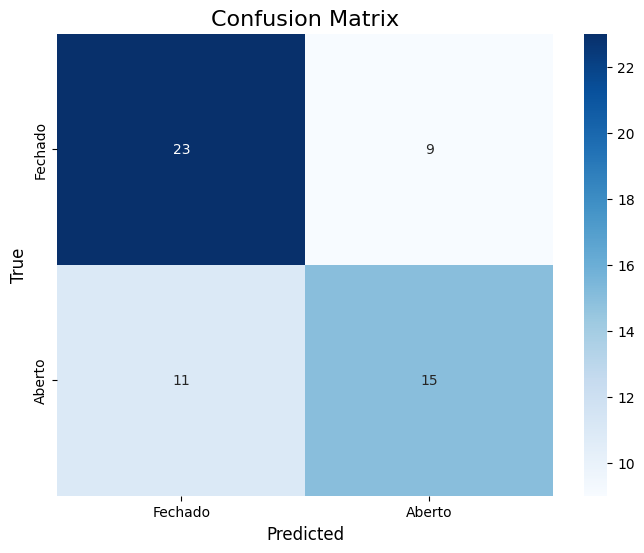

In [ ]:
# Lista para armazenar os resultados de cada fold
accuracy_MLP_All_Features = []
f1_score_MLP_All_Features = []


skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

n_features = X.shape[1] * 22 # Quantidade de features extraidas dos sinais

fold = 1
for train_index, test_index  in skfolds.split(X, y):
    print(f'-------------------- Fold {fold} --------------------')
    keras.backend.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    tf.keras.utils.set_random_seed(SEED)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=[n_features]),
      tf.keras.layers.Dense(n_features, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    X_train_channels = X[train_index]
    y_train = y[train_index]

    X_test_channels = X[test_index]
    y_test = y[test_index]

    # Scale the eeg channels to uses in catch22
    sdt_scale_eeg_channels = StandardScaler()
    X_train_channels = sdt_scale_eeg_channels.fit_transform(X_train_channels.reshape(-1, X_train_channels.shape[-1])).reshape(X_train_channels.shape)
    X_test_channels = sdt_scale_eeg_channels.transform(X_test_channels.reshape(-1, X_test_channels.shape[-1])).reshape(X_test_channels.shape)

    # Aplica o catch22 no X_train_features
    c22 = Catch22()
    X_train_features = c22.fit_transform(X_train_channels)
    X_test_features = c22.transform(X_test_channels)

    # Normaliza as features
    sdt_scale_features = StandardScaler()
    X_train_features = sdt_scale_features.fit_transform(X_train_features.reshape(-1, X_train_features.shape[-1])).reshape(X_train_features.shape)
    X_test_features = sdt_scale_features.transform(X_test_features.reshape(-1, X_test_features.shape[-1])).reshape(X_test_features.shape)


    history = model.fit(X_train_features, y_train, epochs=epochs, batch_size=batch_size)

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()


    predict = model.predict(X_test_features)
    predict[predict > 0.5] = 1
    predict[predict < 0.5] = 0

    accuracy,  f1_, _, _ =metrics(y_test, predict)
    accuracy_MLP_All_Features.append(accuracy)
    f1_score_MLP_All_Features.append(f1_)

    print(f'\n PERFORMANCE MLP')
    print(classification_report(y_test, predict))

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predict)

    # Get class labels from the dataset
    class_names = ['Fechado', 'Aberto']

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    fold += 1

In [ ]:
print('Performance do modelo MLP com as features extraidas de todos os canais) (mean and std)')
print(f'Accuracy: {round(np.mean(accuracy_MLP_All_Features), 3)} +/- {round(np.std(accuracy_MLP_All_Features), 3)}')
print(f'F1 score (macro): {round(np.mean(f1_score_MLP_All_Features), 3)} +/- {round(np.std(f1_score_MLP_All_Features), 3)}')

Performance do modelo MLP com as features extraidas de todos os canais) (mean and std)
Accuracy: 0.651 +/- 0.025
F1 score (macro): 0.594 +/- 0.028


# Multi Layer Perceptron (Usa somente as features extraidas dos canais O1 e O2 como entrada)

-------------------- Fold 1 --------------------
Epoch 1/100
29/29 [==============================] - 1s 3ms/step - loss: 0.7920 - accuracy: 0.4741
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7777 - accuracy: 0.4828
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7663 - accuracy: 0.5172
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7558 - accuracy: 0.5172
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7456 - accuracy: 0.5216
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7371 - accuracy: 0.5345
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7293 - accuracy: 0.5431
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.5431
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7145 - accuracy: 0.5388
Epoch 10/100
29/29 [==============================] - 0s 3ms

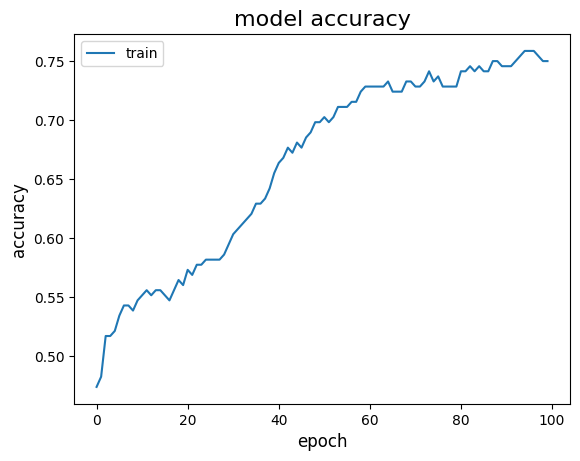

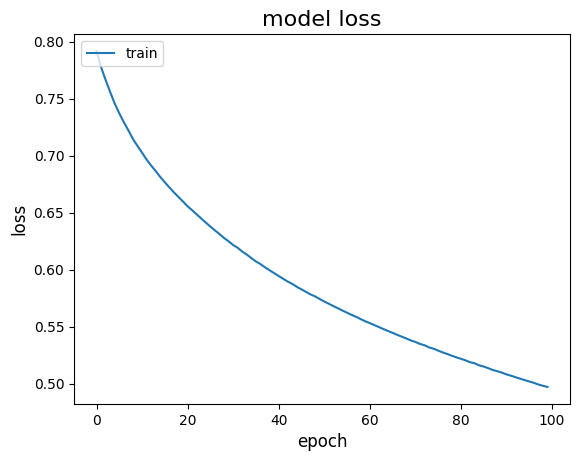

2/2 [==============================] - 0s 6ms/step
Accuracy: 0.534
F1 score: 0.449
Precision: 0.478
Recall: 0.423

 PERFORMANCE MLP
              precision    recall  f1-score   support

           0       0.57      0.62      0.60        32
           1       0.48      0.42      0.45        26

    accuracy                           0.53        58
   macro avg       0.52      0.52      0.52        58
weighted avg       0.53      0.53      0.53        58



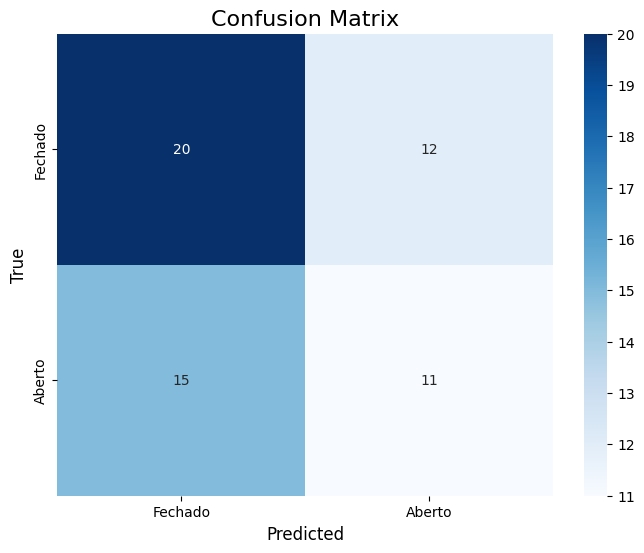

-------------------- Fold 2 --------------------
Epoch 1/100
29/29 [==============================] - 1s 3ms/step - loss: 0.7769 - accuracy: 0.4698
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7629 - accuracy: 0.4784
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7518 - accuracy: 0.5000
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7410 - accuracy: 0.5086
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7315 - accuracy: 0.5302
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7231 - accuracy: 0.5388
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7143 - accuracy: 0.5388
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.5603
Epoch 10/100
29/29 [==============================] - 0s 3ms

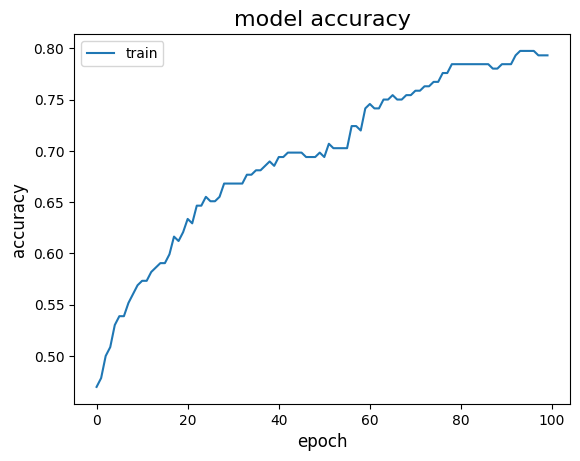

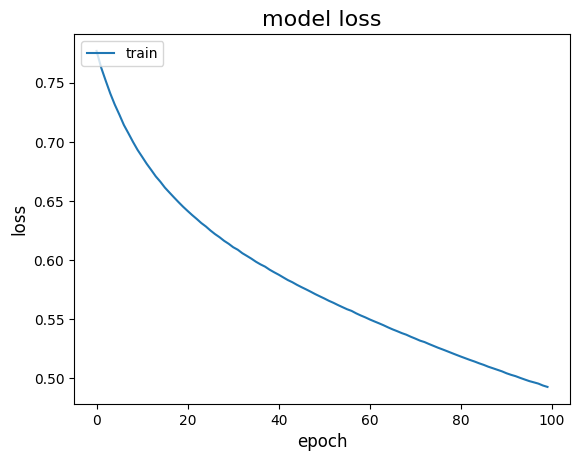

2/2 [==============================] - 0s 12ms/step
Accuracy: 0.483
F1 score: 0.444
Precision: 0.429
Recall: 0.462

 PERFORMANCE MLP
              precision    recall  f1-score   support

           0       0.53      0.50      0.52        32
           1       0.43      0.46      0.44        26

    accuracy                           0.48        58
   macro avg       0.48      0.48      0.48        58
weighted avg       0.49      0.48      0.48        58



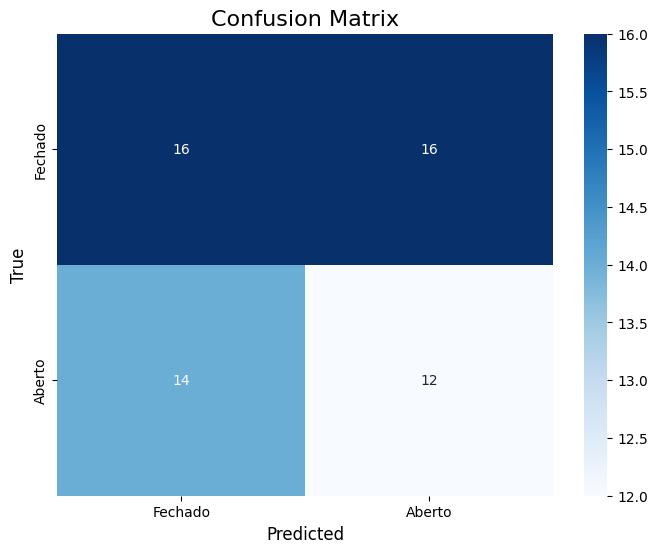

-------------------- Fold 3 --------------------
Epoch 1/100
29/29 [==============================] - 1s 5ms/step - loss: 0.7693 - accuracy: 0.5259
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7582 - accuracy: 0.5474
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7488 - accuracy: 0.5474
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7400 - accuracy: 0.5517
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7323 - accuracy: 0.5517
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7249 - accuracy: 0.5474
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7176 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.5560
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7054 - accuracy: 0.5603
Epoch 10/100
29/29 [==============================] - 0s 4ms

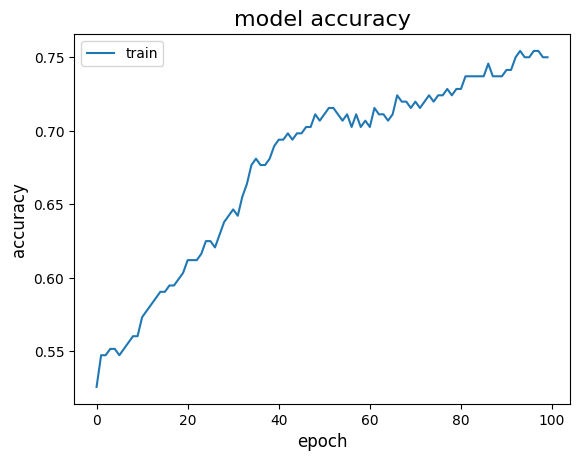

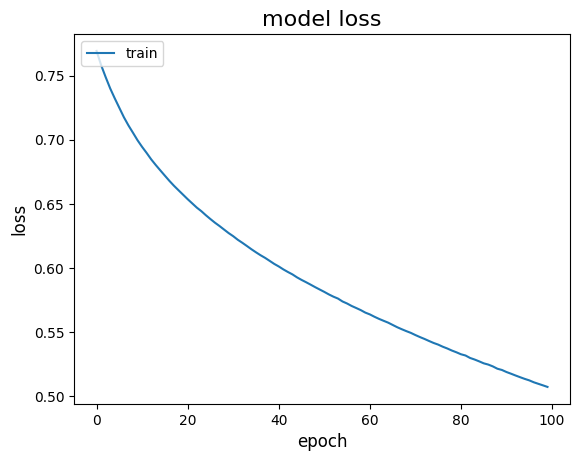

2/2 [==============================] - 0s 6ms/step
Accuracy: 0.569
F1 score: 0.561
Precision: 0.516
Recall: 0.615

 PERFORMANCE MLP
              precision    recall  f1-score   support

           0       0.63      0.53      0.58        32
           1       0.52      0.62      0.56        26

    accuracy                           0.57        58
   macro avg       0.57      0.57      0.57        58
weighted avg       0.58      0.57      0.57        58



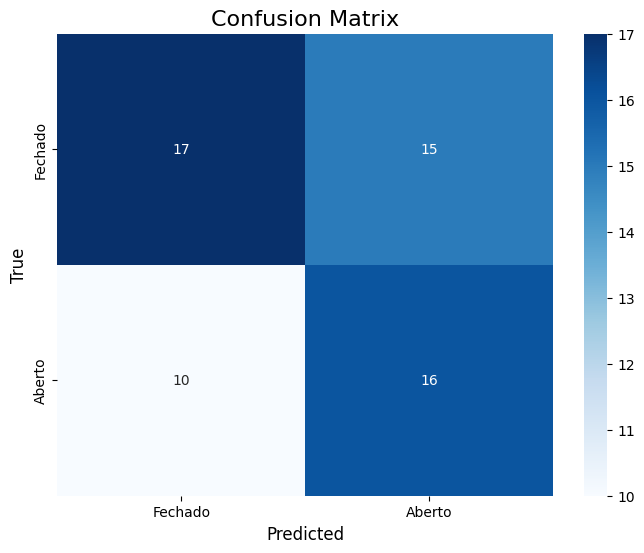

-------------------- Fold 4 --------------------
Epoch 1/100
29/29 [==============================] - 1s 3ms/step - loss: 0.7783 - accuracy: 0.5302
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7670 - accuracy: 0.5388
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7574 - accuracy: 0.5388
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7485 - accuracy: 0.5388
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7405 - accuracy: 0.5302
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7324 - accuracy: 0.5172
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7252 - accuracy: 0.5259
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7185 - accuracy: 0.5259
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7120 - accuracy: 0.5302
Epoch 10/100
29/29 [==============================] - 0s 3ms

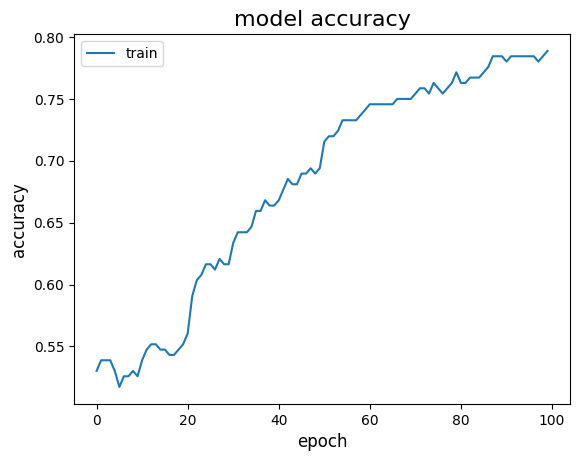

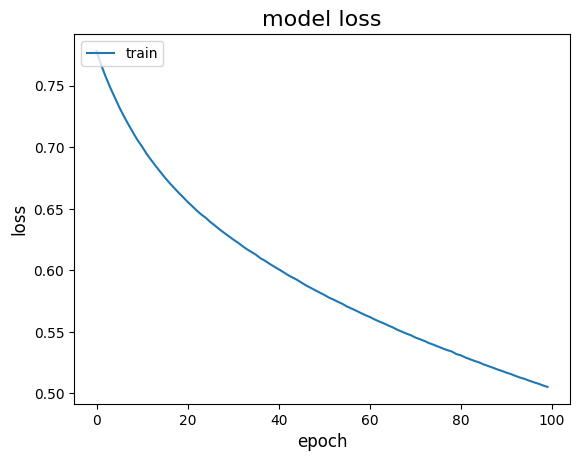

2/2 [==============================] - 0s 8ms/step
Accuracy: 0.5
F1 score: 0.491
Precision: 0.452
Recall: 0.538

 PERFORMANCE MLP
              precision    recall  f1-score   support

           0       0.56      0.47      0.51        32
           1       0.45      0.54      0.49        26

    accuracy                           0.50        58
   macro avg       0.50      0.50      0.50        58
weighted avg       0.51      0.50      0.50        58



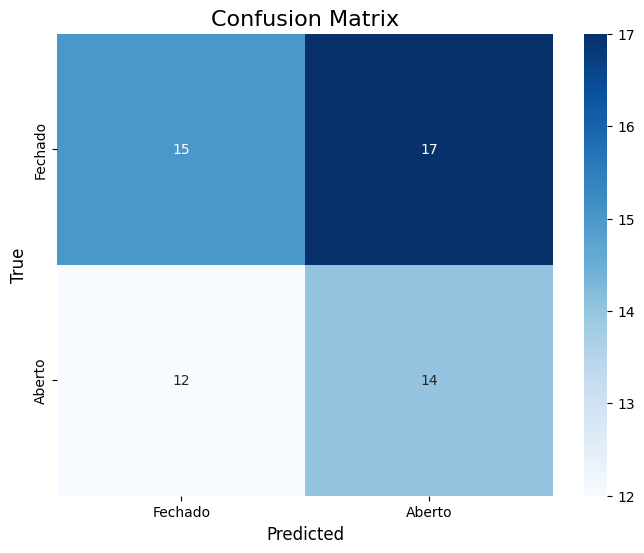

-------------------- Fold 5 --------------------
Epoch 1/100
29/29 [==============================] - 1s 3ms/step - loss: 0.7856 - accuracy: 0.4698
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7732 - accuracy: 0.4871
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7629 - accuracy: 0.5000
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7536 - accuracy: 0.5086
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7447 - accuracy: 0.5259
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7373 - accuracy: 0.5302
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7296 - accuracy: 0.5259
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7226 - accuracy: 0.5302
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 0.5345
Epoch 10/100
29/29 [==============================] - 0s 3ms

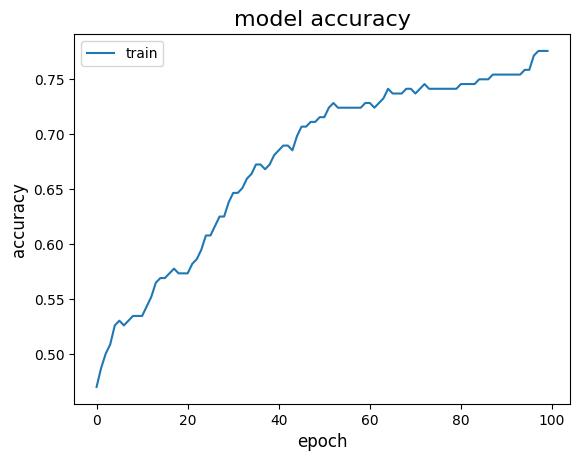

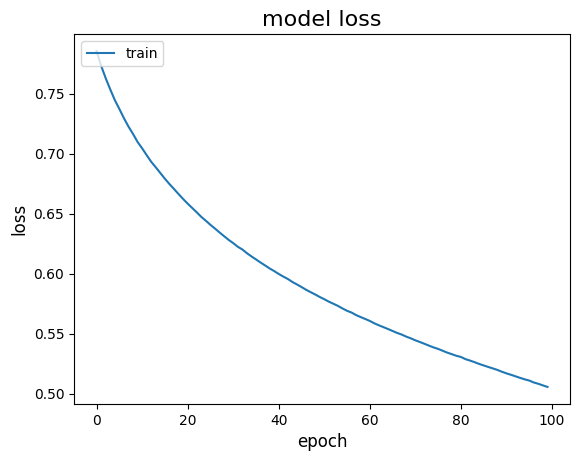

2/2 [==============================] - 0s 7ms/step
Accuracy: 0.586
F1 score: 0.455
Precision: 0.556
Recall: 0.385

 PERFORMANCE MLP
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        32
           1       0.56      0.38      0.45        26

    accuracy                           0.59        58
   macro avg       0.58      0.57      0.56        58
weighted avg       0.58      0.59      0.57        58



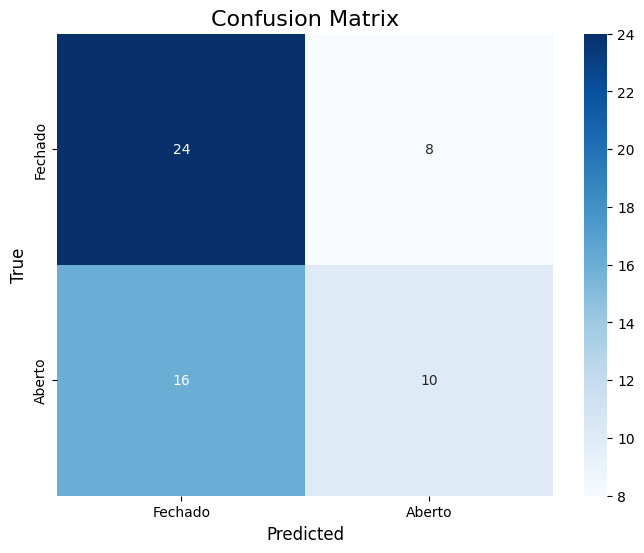

In [ ]:
# Lista para armazenar os resultados de cada fold
accuracy_MLP_Features_From_O1_O2 = []
f1_score_MLP_Features_From_O1_O2 = []


skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

n_features = X_channels.shape[1] * 22 # Quantidade de features extraidas dos sinais

fold = 1
for train_index, test_index  in skfolds.split(X, y):
    print(f'-------------------- Fold {fold} --------------------')
    keras.backend.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    tf.keras.utils.set_random_seed(SEED)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=[n_features]),
      tf.keras.layers.Dense(n_features, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    X_train_channels = X_channels[train_index]
    y_train = y[train_index]

    X_test_channels = X_channels[test_index]
    y_test = y[test_index]

    # Scale the eeg channels to uses in catch22
    sdt_scale_eeg_channels = StandardScaler()
    X_train_channels = sdt_scale_eeg_channels.fit_transform(X_train_channels.reshape(-1, X_train_channels.shape[-1])).reshape(X_train_channels.shape)
    X_test_channels = sdt_scale_eeg_channels.transform(X_test_channels.reshape(-1, X_test_channels.shape[-1])).reshape(X_test_channels.shape)

    # Aplica o catch22 no X_train_features
    c22 = Catch22()
    X_train_features = c22.fit_transform(X_train_channels)
    X_test_features = c22.transform(X_test_channels)

    # Normaliza as features
    sdt_scale_features = StandardScaler()
    X_train_features = sdt_scale_features.fit_transform(X_train_features.reshape(-1, X_train_features.shape[-1])).reshape(X_train_features.shape)
    X_test_features = sdt_scale_features.transform(X_test_features.reshape(-1, X_test_features.shape[-1])).reshape(X_test_features.shape)


    history = model.fit(X_train_features, y_train, epochs=epochs, batch_size=batch_size)

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()


    predict = model.predict(X_test_features)
    predict[predict > 0.5] = 1
    predict[predict < 0.5] = 0

    accuracy,  f1_, _, _ =metrics(y_test, predict)
    accuracy_MLP_Features_From_O1_O2.append(accuracy)
    f1_score_MLP_Features_From_O1_O2.append(f1_)

    print(f'\n PERFORMANCE MLP')
    print(classification_report(y_test, predict))

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predict)

    # Get class labels from the dataset
    class_names = ['Fechado', 'Aberto']

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    fold += 1

In [ ]:
print('Performance do modelo MLP com as features extraidas somente dos canais O1 e O2) (mean and std)')
print(f'Accuracy: {round(np.mean(accuracy_MLP_Features_From_O1_O2), 3)} +/- {round(np.std(accuracy_MLP_Features_From_O1_O2), 3)}')
print(f'F1 score (macro): {round(np.mean(f1_score_MLP_Features_From_O1_O2), 3)} +/- {round(np.std(f1_score_MLP_Features_From_O1_O2), 3)}')

Performance do modelo MLP com as features extraidas somente dos canais O1 e O2) (mean and std)
Accuracy: 0.534 +/- 0.039
F1 score (macro): 0.48 +/- 0.044


# Comparação dos modelos

In [ ]:
print('Performance do modelo CNN + LSTM + Features de todos os canais (mean and std)')
print(f'Accuracy: {round(np.mean(accuracy_CNN_LSTM_All_Features), 3)} +/- {round(np.std(accuracy_CNN_LSTM_All_Features), 3)}')
print(f'F1 score (macro): {round(np.mean(f1_score_CNN_LSTM_All_Features), 3)} +/- {round(np.std(f1_score_CNN_LSTM_All_Features), 3)}')
print()

print('Performance do modelo CNN + LSTM + Features dos canais O1 e O2 (mean and std)')
print(f'Accuracy: {round(np.mean(accuracy_CNN_LSTM_Features_From_O1_O2), 3)} +/- {round(np.std(accuracy_CNN_LSTM_Features_From_O1_O2), 3)}')
print(f'F1 score (macro): {round(np.mean(f1_score_CNN_LSTM_Features_From_O1_O2), 3)} +/- {round(np.std(f1_score_CNN_LSTM_Features_From_O1_O2), 3)}')
print()

print('Performance do modelo CNN + LSTM (mean and std)')
print(f'Accuracy: {round(np.mean(accuracy_CNN_LSTM), 3)} +/- {round(np.std(accuracy_CNN_LSTM), 3)}')
print(f'F1 score (macro): {round(np.mean(f1_score_CNN_LSTM), 3)} +/- {round(np.std(f1_score_CNN_LSTM), 3)}')
print()

print('Performance do modelo MLP com as features extraidas de todos os canais) (mean and std)')
print(f'Accuracy: {round(np.mean(accuracy_MLP_All_Features), 3)} +/- {round(np.std(accuracy_MLP_All_Features), 3)}')
print(f'F1 score (macro): {round(np.mean(f1_score_MLP_All_Features), 3)} +/- {round(np.std(f1_score_MLP_All_Features), 3)}')
print()

print('Performance do modelo MLP com as features extraidas somente dos canais O1 e O2) (mean and std)')
print(f'Accuracy: {round(np.mean(accuracy_MLP_Features_From_O1_O2), 3)} +/- {round(np.std(accuracy_MLP_Features_From_O1_O2), 3)}')
print(f'F1 score (macro): {round(np.mean(f1_score_MLP_Features_From_O1_O2), 3)} +/- {round(np.std(f1_score_MLP_Features_From_O1_O2), 3)}')

Performance do modelo CNN + LSTM + Features de todos os canais (mean and std)
Accuracy: 0.748 +/- 0.048
F1 score (macro): 0.718 +/- 0.054

Performance do modelo CNN + LSTM + Features dos canais O1 e O2 (mean and std)
Accuracy: 0.727 +/- 0.048
F1 score (macro): 0.687 +/- 0.06

Performance do modelo CNN + LSTM (mean and std)
Accuracy: 0.724 +/- 0.044
F1 score (macro): 0.69 +/- 0.048

Performance do modelo MLP com as features extraidas de todos os canais) (mean and std)
Accuracy: 0.651 +/- 0.025
F1 score (macro): 0.594 +/- 0.028

Performance do modelo MLP com as features extraidas somente dos canais O1 e O2) (mean and std)
Accuracy: 0.534 +/- 0.039
F1 score (macro): 0.48 +/- 0.044


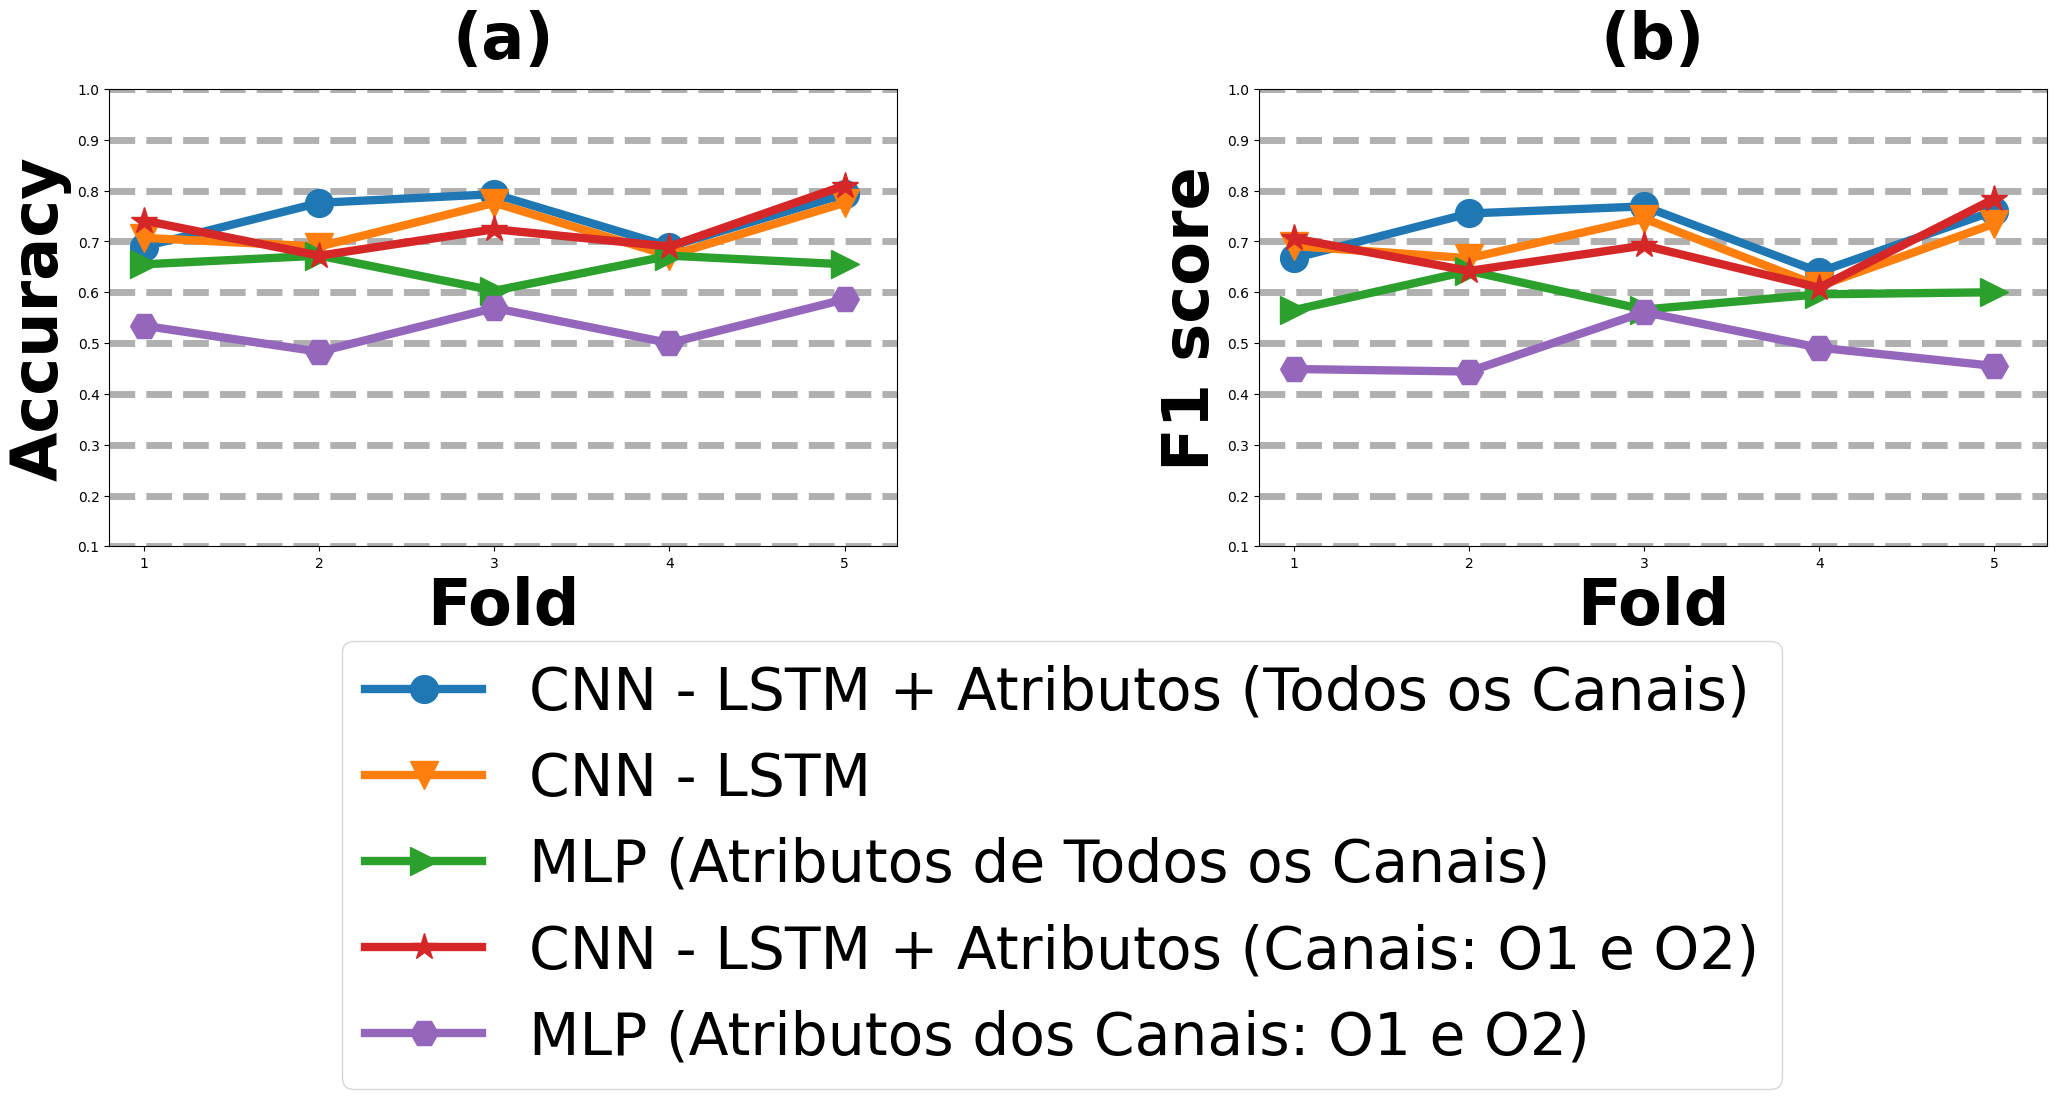

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(25, 30))
gs = gridspec.GridSpec(4,7 ,figure=fig)
gs.update(wspace = 0.35, hspace = 0.35)


ax1 = plt.subplot(gs[0, 0:3])
ax2 = plt.subplot(gs[0,4:])


line_size = 6
marker_size = 20
line_axis_size = 5
line_type = '-'

# Plot ax1 (Accuracy)
# CNN - LSTM + All Features
ax1.plot([1 ,2, 3, 4, 5], accuracy_CNN_LSTM_All_Features, linestyle=line_type, marker="o", linewidth=line_size, markersize=marker_size)

# CNN - LSTM
ax1.plot([1 ,2, 3, 4, 5], accuracy_CNN_LSTM, linestyle=line_type, marker="v", linewidth=line_size, markersize=marker_size)

# MLP All Features
ax1.plot([1 ,2, 3, 4, 5], accuracy_MLP_All_Features, linestyle=line_type, marker=">", linewidth=line_size, markersize=marker_size)


# CNN - LSTM + O1 e O2
ax1.plot([1 ,2, 3, 4, 5], accuracy_CNN_LSTM_Features_From_O1_O2, linestyle=line_type, marker="*", linewidth=line_size, markersize=marker_size)

# MLP O1 e O@
ax1.plot([1 ,2, 3, 4, 5], accuracy_MLP_Features_From_O1_O2, linestyle=line_type, marker="H", linewidth=line_size, markersize=marker_size)


ax1.set_yticks(np.arange(0.10, 1.10, 0.10))
ax1.set_xticks([1, 2, 3, 4, 5])
ax1.grid(axis='y', linestyle='--', linewidth=line_axis_size)
ax1.grid(axis='x', visible=False)
ax1.set_title('(a)', weight='bold', loc='center', pad=22, fontsize=46)
ax1.set_ylabel('Accuracy', weight='bold',fontsize=46)
ax1.set_xlabel('Fold', weight='bold',fontsize=46)
ax1.set_xlim(0.80, 5.3)




# Plot ax2 (F1 score)
# CNN - LSTM + All Features
ax2.plot([1 ,2, 3, 4, 5], f1_score_CNN_LSTM_All_Features, linestyle=line_type, marker="o", linewidth=line_size, markersize=marker_size)

# CNN - LSTM
ax2.plot([1 ,2, 3, 4, 5], f1_score_CNN_LSTM, linestyle=line_type, marker="v", linewidth=line_size, markersize=marker_size)

# MLP All Features
ax2.plot([1 ,2, 3, 4, 5], f1_score_MLP_All_Features, linestyle=line_type, marker=">", linewidth=line_size, markersize=marker_size)

# CNN - LSTM + O1 e O2
ax2.plot([1 ,2, 3, 4, 5], f1_score_CNN_LSTM_Features_From_O1_O2, linestyle=line_type, marker="*", linewidth=line_size, markersize=marker_size)

# MLP O1 e O2
ax2.plot([1 ,2, 3, 4, 5], f1_score_MLP_Features_From_O1_O2, linestyle=line_type, marker="H", linewidth=line_size, markersize=marker_size)


ax2.set_yticks(np.arange(0.10, 1.10, 0.10))
ax2.set_xticks([1, 2, 3, 4, 5])
ax2.grid(axis='y', linestyle='--', linewidth=line_axis_size)
ax2.grid(axis='x', visible=False)
ax2.set_title('(b)', weight='bold', loc='center', pad=22, fontsize=46)
ax2.set_ylabel('F1 score', weight='bold',fontsize=46)
ax2.set_xlabel('Fold', weight='bold',fontsize=46)
ax2.set_xlim(0.80, 5.3)



# Legenda
plt.legend(['CNN - LSTM + Atributos (Todos os Canais)', 'CNN - LSTM', 'MLP (Atributos de Todos os Canais)', 'CNN - LSTM + Atributos (Canais: O1 e O2)', 'MLP (Atributos dos Canais: O1 e O2)'], bbox_to_anchor=(-0.25, -1.25), loc="lower center",ncol=1, fontsize=42)

plt.savefig(f'resultados_validacao_cruzada.pdf',
             dpi=600, bbox_inches="tight")

plt.show()
